# mimic_data_generator

In [8]:
# mimic_data_generator.py
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import networkx as nx
from datetime import datetime, timedelta
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# ============================================
# 1. CREATE MIMIC GRID TOPOLOGY
# ============================================

def create_grid_topology():
    """Create a realistic grid with 3 LV networks under 1 MV transformer"""
    
    grid_data = {
        'substations': [],
        'mv_transformers': [],
        'lv_networks': [],
        'lv_cables': [],
        'mv_cables': []
    }
    
    # Create 1 substation
    substation = {
        'id': 'SUB_001',
        'x': 100000,
        'y': 450000,
        'capacity_mva': 50,
        'geometry': Point(100000, 450000)
    }
    grid_data['substations'].append(substation)
    
    # Create 2 MV transformers
    mv_positions = [(100200, 450100), (100400, 449900)]
    for i, pos in enumerate(mv_positions):
        mv_transformer = {
            'id': f'MV_TRANS_{i+1:03d}',
            'x': pos[0],
            'y': pos[1],
            'capacity_kva': 1000,
            'substation_id': 'SUB_001',
            'geometry': Point(pos[0], pos[1])
        }
        grid_data['mv_transformers'].append(mv_transformer)
        
        # MV cable from substation to transformer
        mv_cable = {
            'id': f'MV_CABLE_{i+1:03d}',
            'from_node': 'SUB_001',
            'to_node': f'MV_TRANS_{i+1:03d}',
            'length_m': np.sqrt((pos[0]-100000)**2 + (pos[1]-450000)**2),
            'geometry': LineString([Point(100000, 450000), Point(pos[0], pos[1])])
        }
        grid_data['mv_cables'].append(mv_cable)
    
    # Create 3 LV networks per MV transformer
    lv_id = 1
    for mv_idx, mv_trans in enumerate(grid_data['mv_transformers']):
        for lv_net in range(3):
            # Position LV networks around MV transformer
            angle = lv_net * 120 * np.pi / 180
            lv_x = mv_trans['x'] + 150 * np.cos(angle)
            lv_y = mv_trans['y'] + 150 * np.sin(angle)
            
            lv_network = {
                'id': f'LV_NET_{lv_id:03d}',
                'component_id': lv_id,
                'x': lv_x,
                'y': lv_y,
                'mv_transformer_id': mv_trans['id'],
                'capacity_kva': 250,
                'geometry': Point(lv_x, lv_y)
            }
            grid_data['lv_networks'].append(lv_network)
            
            # Create LV cables (simplified as single line)
            lv_cable = {
                'id': f'LV_CABLE_{lv_id:03d}',
                'component_id': lv_id,
                'from_node': mv_trans['id'],
                'to_node': f'LV_NET_{lv_id:03d}',
                'length_m': 150,
                'geometry': LineString([Point(mv_trans['x'], mv_trans['y']), 
                                       Point(lv_x, lv_y)])
            }
            grid_data['lv_cables'].append(lv_cable)
            lv_id += 1
    
    return grid_data

# ============================================
# 2. CREATE MIMIC BUILDINGS
# ============================================

def create_buildings(grid_data):
    """Create diverse buildings assigned to LV networks"""
    
    buildings = []
    building_id = 1
    
    # Building type distributions
    building_configs = [
        # LV_NET_001: Residential heavy (morning/evening peaks)
        {'lv_id': 'LV_NET_001', 'residential': 20, 'office': 2, 'retail': 3, 'industrial': 1},
        # LV_NET_002: Mixed use (good complementarity)
        {'lv_id': 'LV_NET_002', 'residential': 10, 'office': 8, 'retail': 4, 'industrial': 2},
        # LV_NET_003: Commercial heavy (daytime peaks)
        {'lv_id': 'LV_NET_003', 'residential': 5, 'office': 12, 'retail': 6, 'industrial': 2},
        # LV_NET_004: Residential cluster
        {'lv_id': 'LV_NET_004', 'residential': 25, 'office': 1, 'retail': 2, 'industrial': 0},
        # LV_NET_005: Industrial mixed
        {'lv_id': 'LV_NET_005', 'residential': 8, 'office': 4, 'retail': 2, 'industrial': 6},
        # LV_NET_006: Small mixed
        {'lv_id': 'LV_NET_006', 'residential': 12, 'office': 3, 'retail': 3, 'industrial': 1}
    ]
    
    for config in building_configs:
        lv_network = next(lv for lv in grid_data['lv_networks'] if lv['id'] == config['lv_id'])
        
        # Generate buildings around LV network center
        for building_type, count in config.items():
            if building_type == 'lv_id':
                continue
                
            for i in range(count):
                # Random position around LV network (within 100m)
                angle = random.uniform(0, 2*np.pi)
                distance = random.uniform(10, 100)
                x = lv_network['x'] + distance * np.cos(angle)
                y = lv_network['y'] + distance * np.sin(angle)
                
                # Building attributes based on type
                if building_type == 'residential':
                    area = random.choice([80, 100, 120, 150, 200])
                    height = random.choice([3, 6, 9, 12])
                    residential_subtype = random.choice(['Detached', 'Semi-detached', 
                                                        'Terrace', 'Apartment'])
                    orientation = random.choice(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
                    roof_area = area * 0.6 if residential_subtype != 'Apartment' else area * 0.3
                    
                elif building_type == 'office':
                    area = random.choice([200, 400, 600, 800, 1000])
                    height = random.choice([12, 15, 18, 21])
                    residential_subtype = None
                    orientation = random.choice(['N', 'E', 'S', 'W'])
                    roof_area = area * 0.4
                    
                elif building_type == 'retail':
                    area = random.choice([150, 300, 500, 750])
                    height = random.choice([6, 9, 12])
                    residential_subtype = None
                    orientation = random.choice(['N', 'E', 'S', 'W'])
                    roof_area = area * 0.5
                    
                else:  # industrial
                    area = random.choice([500, 1000, 1500, 2000])
                    height = random.choice([9, 12, 15])
                    residential_subtype = None
                    orientation = 'Flat'
                    roof_area = area * 0.7
                
                building = {
                    'ogc_fid': building_id,
                    'x': x,
                    'y': y,
                    'building_function': 'residential' if building_type == 'residential' else 'non_residential',
                    'residential_type': residential_subtype,
                    'non_residential_type': building_type.capitalize() if building_type != 'residential' else None,
                    'area': area,
                    'height': height,
                    'age_range': random.choice(['<1945', '1945-1975', '1975-1995', '1995-2015', '>2015']),
                    'building_orientation_cardinal': orientation,
                    'roof_area': roof_area,
                    'flat_roof_area': roof_area if orientation == 'Flat' else roof_area * 0.3,
                    'sloped_roof_area': 0 if orientation == 'Flat' else roof_area * 0.7,
                    'lv_component_id': lv_network['component_id'],
                    'lv_network_id': lv_network['id'],
                    'geometry': Point(x, y)
                }
                buildings.append(building)
                building_id += 1
    
    return pd.DataFrame(buildings)
















def add_shared_wall_data(buildings_df):
    """
    Add realistic shared wall data based on building positions
    Creates row houses, corner configurations, and isolated buildings
    """
    
    # Initialize all wall columns
    for side in ['north', 'south', 'east', 'west']:
        buildings_df[f'{side}_side'] = True  # All buildings have 4 walls
        buildings_df[f'{side}_shared_length'] = 0.0
        buildings_df[f'{side}_facade_length'] = 10.0  # Default 10m per wall
    
    # Group buildings by LV network for local processing
    for lv_network in buildings_df['lv_network_id'].unique():
        lv_buildings = buildings_df[buildings_df['lv_network_id'] == lv_network].copy()
        
        # Create different adjacency patterns based on building types
        residential_buildings = lv_buildings[lv_buildings['building_function'] == 'residential']
        
        # Pattern 1: Row Houses (Terraces)
        # Find clusters of residential buildings that could form rows
        if len(residential_buildings) >= 3:
            # Sort by x coordinate to create east-west rows
            sorted_res = residential_buildings.sort_values('x').head(6)  # Take up to 6 for a row
            
            for i in range(len(sorted_res) - 1):
                idx_current = sorted_res.iloc[i].name
                idx_next = sorted_res.iloc[i + 1].name
                
                # Check if buildings are close enough to be row houses
                if abs(sorted_res.iloc[i]['x'] - sorted_res.iloc[i + 1]['x']) < 15:
                    # Current building shares east wall
                    buildings_df.at[idx_current, 'east_shared_length'] = 8.0
                    buildings_df.at[idx_current, 'east_facade_length'] = 2.0
                    
                    # Next building shares west wall
                    buildings_df.at[idx_next, 'west_shared_length'] = 8.0
                    buildings_df.at[idx_next, 'west_facade_length'] = 2.0
        
        # Pattern 2: Corner Configuration (L-shapes)
        # Find buildings that could form corner clusters
        for idx, building in lv_buildings.iterrows():
            # Find potential neighbors
            nearby = lv_buildings[
                (lv_buildings.index != idx) &
                (((lv_buildings['x'] - building['x']).abs() < 15) |
                 ((lv_buildings['y'] - building['y']).abs() < 15))
            ]
            
            for n_idx, neighbor in nearby.iterrows():
                dx = neighbor['x'] - building['x']
                dy = neighbor['y'] - building['y']
                
                # North-South adjacency
                if abs(dx) < 5 and dy > 0 and dy < 15:  # Neighbor is north
                    if buildings_df.at[idx, 'north_shared_length'] == 0:  # Not already shared
                        shared_length = 6.0 if building['residential_type'] == 'Apartment' else 8.0
                        buildings_df.at[idx, 'north_shared_length'] = shared_length
                        buildings_df.at[idx, 'north_facade_length'] = 10.0 - shared_length
                        buildings_df.at[n_idx, 'south_shared_length'] = shared_length
                        buildings_df.at[n_idx, 'south_facade_length'] = 10.0 - shared_length
                
                elif abs(dx) < 5 and dy < 0 and dy > -15:  # Neighbor is south
                    if buildings_df.at[idx, 'south_shared_length'] == 0:
                        shared_length = 6.0 if building['residential_type'] == 'Apartment' else 8.0
                        buildings_df.at[idx, 'south_shared_length'] = shared_length
                        buildings_df.at[idx, 'south_facade_length'] = 10.0 - shared_length
                        buildings_df.at[n_idx, 'north_shared_length'] = shared_length
                        buildings_df.at[n_idx, 'north_facade_length'] = 10.0 - shared_length
                
                # East-West adjacency (if not already in row house)
                elif abs(dy) < 5 and dx > 0 and dx < 15:  # Neighbor is east
                    if buildings_df.at[idx, 'east_shared_length'] == 0:
                        shared_length = 7.0
                        buildings_df.at[idx, 'east_shared_length'] = shared_length
                        buildings_df.at[idx, 'east_facade_length'] = 10.0 - shared_length
                        buildings_df.at[n_idx, 'west_shared_length'] = shared_length
                        buildings_df.at[n_idx, 'west_facade_length'] = 10.0 - shared_length
                
                elif abs(dy) < 5 and dx < 0 and dx > -15:  # Neighbor is west
                    if buildings_df.at[idx, 'west_shared_length'] == 0:
                        shared_length = 7.0
                        buildings_df.at[idx, 'west_shared_length'] = shared_length
                        buildings_df.at[idx, 'west_facade_length'] = 10.0 - shared_length
                        buildings_df.at[n_idx, 'east_shared_length'] = shared_length
                        buildings_df.at[n_idx, 'east_facade_length'] = 10.0 - shared_length
    
    # Pattern 3: Apartment blocks (multiple shared walls)
    apartments = buildings_df[buildings_df['residential_type'] == 'Apartment']
    for idx, apt in apartments.iterrows():
        # Apartments often share 2-3 walls
        nearby_apts = apartments[
            (apartments.index != idx) &
            (((apartments['x'] - apt['x']).abs() < 10) &
             ((apartments['y'] - apt['y']).abs() < 10))
        ]
        
        if len(nearby_apts) >= 2:
            # Create a more complex sharing pattern
            buildings_df.at[idx, 'north_shared_length'] = 9.0
            buildings_df.at[idx, 'north_facade_length'] = 1.0
            buildings_df.at[idx, 'east_shared_length'] = 9.0
            buildings_df.at[idx, 'east_facade_length'] = 1.0
    
    # Add summary statistics
    buildings_df['num_shared_walls'] = (
        (buildings_df['north_shared_length'] > 0).astype(int) +
        (buildings_df['south_shared_length'] > 0).astype(int) +
        (buildings_df['east_shared_length'] > 0).astype(int) +
        (buildings_df['west_shared_length'] > 0).astype(int)
    )
    
    buildings_df['total_shared_length'] = (
        buildings_df['north_shared_length'] +
        buildings_df['south_shared_length'] +
        buildings_df['east_shared_length'] +
        buildings_df['west_shared_length']
    )
    
    buildings_df['adjacency_type'] = buildings_df.apply(classify_adjacency_type, axis=1)
    
    return buildings_df

def classify_adjacency_type(row):
    """Classify building adjacency configuration"""
    num_shared = row['num_shared_walls']
    
    if num_shared == 0:
        return 'ISOLATED'
    elif num_shared == 1:
        return 'END_UNIT'
    elif num_shared == 2:
        # Check if opposite or corner
        if (row['north_shared_length'] > 0 and row['south_shared_length'] > 0) or \
           (row['east_shared_length'] > 0 and row['west_shared_length'] > 0):
            return 'MIDDLE_ROW'
        else:
            return 'CORNER'
    elif num_shared == 3:
        return 'THREE_SIDED'
    else:
        return 'ENCLOSED'











# ============================================
# 3. CREATE ENERGY PROFILES
# ============================================

# Fixed version of create_energy_profiles function
def create_energy_profiles(buildings_df, days=7):
    """Create realistic 15-minute energy profiles for each building"""
    
    # Time series index (15-minute intervals for 7 days)
    time_index = pd.date_range(start='2024-01-15', periods=days*24*4, freq='15min')
    
    profiles = {}
    
    for _, building in buildings_df.iterrows():
        building_id = building['ogc_fid']
        
        # Base load patterns by building type
        if building['building_function'] == 'residential':
            # Residential: morning and evening peaks
            base_pattern = np.array([
                0.3, 0.3, 0.25, 0.25,  # 00:00-01:00 (night)
                0.25, 0.25, 0.25, 0.25,  # 01:00-02:00
                0.25, 0.25, 0.25, 0.25,  # 02:00-03:00
                0.25, 0.25, 0.25, 0.25,  # 03:00-04:00
                0.3, 0.35, 0.4, 0.45,   # 04:00-05:00 (early morning)
                0.5, 0.6, 0.7, 0.8,     # 05:00-06:00
                0.9, 1.0, 0.95, 0.9,    # 06:00-07:00 (morning peak)
                0.85, 0.8, 0.75, 0.7,   # 07:00-08:00
                0.6, 0.5, 0.45, 0.4,    # 08:00-09:00
                0.35, 0.35, 0.35, 0.35, # 09:00-10:00 (daytime low)
                0.35, 0.35, 0.35, 0.35, # 10:00-11:00
                0.35, 0.4, 0.45, 0.5,   # 11:00-12:00
                0.55, 0.6, 0.6, 0.55,   # 12:00-13:00 (lunch)
                0.5, 0.45, 0.4, 0.4,    # 13:00-14:00
                0.4, 0.4, 0.4, 0.4,     # 14:00-15:00
                0.4, 0.45, 0.5, 0.55,   # 15:00-16:00
                0.6, 0.65, 0.7, 0.75,   # 16:00-17:00
                0.8, 0.85, 0.9, 0.95,   # 17:00-18:00 (evening rise)
                1.0, 1.0, 0.95, 0.9,    # 18:00-19:00 (evening peak)
                0.85, 0.8, 0.75, 0.7,   # 19:00-20:00
                0.65, 0.6, 0.55, 0.5,   # 20:00-21:00
                0.45, 0.4, 0.35, 0.35,  # 21:00-22:00
                0.35, 0.35, 0.3, 0.3,   # 22:00-23:00
                0.3, 0.3, 0.3, 0.3      # 23:00-00:00
            ])
            peak_demand = building['area'] * 0.03  # 30W/m2 peak
            
        elif building['non_residential_type'] == 'Office':
            # Office: strong daytime peak, minimal night/weekend
            base_pattern = np.array([
                0.15, 0.15, 0.15, 0.15,  # 00:00-01:00 (night minimum)
                0.15, 0.15, 0.15, 0.15,  # 01:00-02:00
                0.15, 0.15, 0.15, 0.15,  # 02:00-03:00
                0.15, 0.15, 0.15, 0.15,  # 03:00-04:00
                0.15, 0.15, 0.15, 0.15,  # 04:00-05:00
                0.15, 0.15, 0.2, 0.25,   # 05:00-06:00
                0.3, 0.4, 0.5, 0.6,      # 06:00-07:00 (startup)
                0.7, 0.8, 0.85, 0.9,     # 07:00-08:00
                0.95, 1.0, 1.0, 1.0,     # 08:00-09:00 (work hours)
                1.0, 1.0, 1.0, 1.0,      # 09:00-10:00
                1.0, 1.0, 1.0, 1.0,      # 10:00-11:00
                1.0, 1.0, 1.0, 1.0,      # 11:00-12:00
                0.9, 0.85, 0.85, 0.9,    # 12:00-13:00 (lunch dip)
                0.95, 1.0, 1.0, 1.0,     # 13:00-14:00
                1.0, 1.0, 1.0, 1.0,      # 14:00-15:00
                1.0, 1.0, 0.95, 0.9,     # 15:00-16:00
                0.85, 0.8, 0.7, 0.6,     # 16:00-17:00 (end of day)
                0.5, 0.4, 0.3, 0.25,     # 17:00-18:00
                0.2, 0.2, 0.18, 0.18,    # 18:00-19:00
                0.17, 0.17, 0.16, 0.16,  # 19:00-20:00
                0.15, 0.15, 0.15, 0.15,  # 20:00-21:00
                0.15, 0.15, 0.15, 0.15,  # 21:00-22:00
                0.15, 0.15, 0.15, 0.15,  # 22:00-23:00
                0.15, 0.15, 0.15, 0.15   # 23:00-00:00
            ])
            peak_demand = building['area'] * 0.05  # 50W/m2 peak
            
        elif building['non_residential_type'] == 'Retail':
            # Retail: late morning to evening
            base_pattern = np.array([
                0.1, 0.1, 0.1, 0.1,      # 00:00-01:00
                0.1, 0.1, 0.1, 0.1,      # 01:00-02:00
                0.1, 0.1, 0.1, 0.1,      # 02:00-03:00
                0.1, 0.1, 0.1, 0.1,      # 03:00-04:00
                0.1, 0.1, 0.1, 0.1,      # 04:00-05:00
                0.1, 0.15, 0.2, 0.25,    # 05:00-06:00
                0.3, 0.35, 0.4, 0.45,    # 06:00-07:00
                0.5, 0.55, 0.6, 0.65,    # 07:00-08:00
                0.7, 0.75, 0.8, 0.85,    # 08:00-09:00
                0.9, 0.95, 1.0, 1.0,     # 09:00-10:00 (opening)
                1.0, 1.0, 1.0, 1.0,      # 10:00-11:00
                1.0, 1.0, 1.0, 1.0,      # 11:00-12:00
                1.0, 1.0, 1.0, 1.0,      # 12:00-13:00
                1.0, 1.0, 1.0, 1.0,      # 13:00-14:00
                1.0, 1.0, 1.0, 1.0,      # 14:00-15:00
                1.0, 1.0, 1.0, 1.0,      # 15:00-16:00
                1.0, 1.0, 1.0, 1.0,      # 16:00-17:00
                1.0, 1.0, 0.95, 0.9,     # 17:00-18:00
                0.85, 0.8, 0.75, 0.7,    # 18:00-19:00
                0.65, 0.6, 0.5, 0.4,     # 19:00-20:00 (closing)
                0.3, 0.25, 0.2, 0.15,    # 20:00-21:00
                0.12, 0.12, 0.11, 0.11,  # 21:00-22:00
                0.1, 0.1, 0.1, 0.1,      # 22:00-23:00
                0.1, 0.1, 0.1, 0.1       # 23:00-00:00
            ])
            peak_demand = building['area'] * 0.06  # 60W/m2 peak
            
        else:  # Industrial
            # Industrial: relatively constant with slight day variation
            base_pattern = np.array([
                0.7, 0.7, 0.7, 0.7,      # 00:00-01:00 (24/7 operation)
                0.7, 0.7, 0.7, 0.7,      # 01:00-02:00
                0.7, 0.7, 0.7, 0.7,      # 02:00-03:00
                0.7, 0.7, 0.7, 0.7,      # 03:00-04:00
                0.7, 0.7, 0.7, 0.7,      # 04:00-05:00
                0.7, 0.75, 0.8, 0.85,    # 05:00-06:00
                0.9, 0.95, 1.0, 1.0,     # 06:00-07:00 (shift start)
                1.0, 1.0, 1.0, 1.0,      # 07:00-08:00
                1.0, 1.0, 1.0, 1.0,      # 08:00-09:00
                1.0, 1.0, 1.0, 1.0,      # 09:00-10:00
                1.0, 1.0, 1.0, 1.0,      # 10:00-11:00
                1.0, 1.0, 1.0, 1.0,      # 11:00-12:00
                1.0, 1.0, 1.0, 1.0,      # 12:00-13:00
                1.0, 1.0, 1.0, 1.0,      # 13:00-14:00
                1.0, 1.0, 1.0, 1.0,      # 14:00-15:00
                1.0, 0.95, 0.9, 0.85,    # 15:00-16:00 (shift change)
                0.8, 0.8, 0.8, 0.8,      # 16:00-17:00
                0.8, 0.8, 0.8, 0.8,      # 17:00-18:00
                0.8, 0.8, 0.8, 0.8,      # 18:00-19:00
                0.8, 0.8, 0.8, 0.8,      # 19:00-20:00
                0.8, 0.75, 0.75, 0.75,   # 20:00-21:00
                0.75, 0.75, 0.7, 0.7,    # 21:00-22:00
                0.7, 0.7, 0.7, 0.7,      # 22:00-23:00
                0.7, 0.7, 0.7, 0.7       # 23:00-00:00
            ])
            peak_demand = building['area'] * 0.08  # 80W/m2 peak
        
        # Generate full time series
        daily_pattern = base_pattern * peak_demand
        
        # Add some randomness and weekly variation
        full_profile = []
        for day in range(days):
            if day % 7 in [5, 6]:  # Weekend
                weekend_factor = 0.6 if building['non_residential_type'] in ['Office', 'Retail'] else 1.1
            else:
                weekend_factor = 1.0
            
            daily_values = daily_pattern * weekend_factor
            # Add noise
            daily_values = daily_values * (1 + np.random.normal(0, 0.05, len(daily_values)))
            daily_values = np.maximum(daily_values, 0)  # No negative values
            full_profile.extend(daily_values)
        
        # Convert to numpy array for multiplication
        full_profile = np.array(full_profile)
        
        profiles[building_id] = {
            'timestamps': time_index[:len(full_profile)],
            'electricity_demand_kw': full_profile,
            'heating_demand_kw': full_profile * 0.5 * (1.5 if building['age_range'] == '<1945' else 1.0),
            'cooling_demand_kw': full_profile * 0.3 * (0.5 if building['building_function'] == 'residential' else 1.0)
        }
    
    return profiles

# ============================================
# 4. CREATE SOLAR & BATTERY PROFILES
# ============================================

def create_solar_profiles(buildings_df, profiles_dict):
    """Add solar generation profiles for suitable buildings"""
    
    solar_profiles = {}
    
    for _, building in buildings_df.iterrows():
        building_id = building['ogc_fid']
        
        # Solar potential based on roof and orientation
        if building['roof_area'] > 50:  # Minimum 50m2 roof
            # Solar capacity (kWp) - 0.15 kW/m2 panel efficiency, 0.7 usable roof area
            if building['building_orientation_cardinal'] in ['S', 'SE', 'SW']:
                solar_capacity_kwp = building['roof_area'] * 0.15 * 0.7
            elif building['building_orientation_cardinal'] in ['E', 'W']:
                solar_capacity_kwp = building['roof_area'] * 0.15 * 0.5
            elif building['building_orientation_cardinal'] == 'Flat':
                solar_capacity_kwp = building['flat_roof_area'] * 0.15 * 0.8
            else:
                solar_capacity_kwp = building['roof_area'] * 0.15 * 0.3
            
            # Generate daily solar pattern (simplified)
            solar_pattern = np.array([
                0, 0, 0, 0,              # 00:00-01:00
                0, 0, 0, 0,              # 01:00-02:00
                0, 0, 0, 0,              # 02:00-03:00
                0, 0, 0, 0,              # 03:00-04:00
                0, 0, 0, 0,              # 04:00-05:00
                0, 0, 0.02, 0.05,        # 05:00-06:00 (sunrise)
                0.1, 0.15, 0.2, 0.25,    # 06:00-07:00
                0.3, 0.35, 0.4, 0.45,    # 07:00-08:00
                0.5, 0.55, 0.6, 0.65,    # 08:00-09:00
                0.7, 0.75, 0.8, 0.85,    # 09:00-10:00
                0.9, 0.93, 0.96, 0.98,   # 10:00-11:00
                1.0, 1.0, 1.0, 1.0,      # 11:00-12:00 (peak)
                1.0, 1.0, 0.98, 0.96,    # 12:00-13:00
                0.93, 0.9, 0.85, 0.8,    # 13:00-14:00
                0.75, 0.7, 0.65, 0.6,    # 14:00-15:00
                0.55, 0.5, 0.45, 0.4,    # 15:00-16:00
                0.35, 0.3, 0.25, 0.2,    # 16:00-17:00
                0.15, 0.1, 0.05, 0.02,   # 17:00-18:00 (sunset)
                0, 0, 0, 0,              # 18:00-19:00
                0, 0, 0, 0,              # 19:00-20:00
                0, 0, 0, 0,              # 20:00-21:00
                0, 0, 0, 0,              # 21:00-22:00
                0, 0, 0, 0,              # 22:00-23:00
                0, 0, 0, 0               # 23:00-00:00
            ])
            
            # Full profile with weather variation
            days = len(profiles_dict[building_id]['timestamps']) // 96
            full_solar = []
            for day in range(days):
                weather_factor = random.choice([0.2, 0.5, 0.8, 0.9, 1.0])  # Cloud cover
                daily_solar = solar_pattern * solar_capacity_kwp * weather_factor
                full_solar.extend(daily_solar)
            
            solar_profiles[building_id] = {
                'solar_capacity_kwp': solar_capacity_kwp,
                'solar_generation_kw': full_solar[:len(profiles_dict[building_id]['timestamps'])]
            }
        else:
            solar_profiles[building_id] = {
                'solar_capacity_kwp': 0,
                'solar_generation_kw': np.zeros(len(profiles_dict[building_id]['timestamps']))
            }
    
    return solar_profiles

def create_battery_profiles(buildings_df, profiles_dict, solar_profiles):
    """Add battery storage and dispatch profiles"""
    
    battery_profiles = {}
    
    for _, building in buildings_df.iterrows():
        building_id = building['ogc_fid']
        
        # Battery sizing (only for buildings with solar)
        if solar_profiles[building_id]['solar_capacity_kwp'] > 0:
            # Battery capacity: 2 kWh per kWp of solar
            battery_capacity_kwh = solar_profiles[building_id]['solar_capacity_kwp'] * 2
            battery_power_kw = battery_capacity_kwh / 4  # C/4 rate
            
            # Simple dispatch logic
            battery_soc = []  # State of charge
            battery_charge = []
            battery_discharge = []
            
            current_soc = battery_capacity_kwh * 0.5  # Start at 50%
            
            for i in range(len(profiles_dict[building_id]['timestamps'])):
                demand = profiles_dict[building_id]['electricity_demand_kw'][i]
                solar = solar_profiles[building_id]['solar_generation_kw'][i]
                
                net_demand = demand - solar
                
                if net_demand < 0:  # Excess solar - charge battery
                    charge_power = min(-net_demand, battery_power_kw, 
                                      battery_capacity_kwh - current_soc)
                    discharge_power = 0
                    current_soc = min(current_soc + charge_power * 0.25, battery_capacity_kwh)
                    
                elif net_demand > 0 and current_soc > battery_capacity_kwh * 0.2:  # Need power - discharge
                    discharge_power = min(net_demand, battery_power_kw, 
                                         current_soc - battery_capacity_kwh * 0.2)
                    charge_power = 0
                    current_soc = max(current_soc - discharge_power * 0.25, 0)
                else:
                    charge_power = 0
                    discharge_power = 0
                
                battery_soc.append(current_soc)
                battery_charge.append(charge_power)
                battery_discharge.append(discharge_power)
            
            battery_profiles[building_id] = {
                'battery_capacity_kwh': battery_capacity_kwh,
                'battery_power_kw': battery_power_kw,
                'battery_soc_kwh': battery_soc,
                'battery_charge_kw': battery_charge,
                'battery_discharge_kw': battery_discharge
            }
        else:
            battery_profiles[building_id] = {
                'battery_capacity_kwh': 0,
                'battery_power_kw': 0,
                'battery_soc_kwh': np.zeros(len(profiles_dict[building_id]['timestamps'])),
                'battery_charge_kw': np.zeros(len(profiles_dict[building_id]['timestamps'])),
                'battery_discharge_kw': np.zeros(len(profiles_dict[building_id]['timestamps']))
            }
    
    return battery_profiles

# ============================================
# 5. GENERATE ALL DATA
# ============================================

print("Creating mimic data...")

# Generate grid topology
grid_data = create_grid_topology()
print(f"✓ Created grid: {len(grid_data['substations'])} substations, "
      f"{len(grid_data['mv_transformers'])} MV transformers, "
      f"{len(grid_data['lv_networks'])} LV networks")

# Generate buildings
buildings_df = create_buildings(grid_data)
print(f"✓ Created {len(buildings_df)} buildings")

# ADD SHARED WALL DATA
buildings_df = add_shared_wall_data(buildings_df)
print(f"✓ Added shared wall data:")
print(f"  - Isolated buildings: {(buildings_df['adjacency_type'] == 'ISOLATED').sum()}")
print(f"  - End units: {(buildings_df['adjacency_type'] == 'END_UNIT').sum()}")
print(f"  - Middle row: {(buildings_df['adjacency_type'] == 'MIDDLE_ROW').sum()}")
print(f"  - Corner buildings: {(buildings_df['adjacency_type'] == 'CORNER').sum()}")
print(f"  - Three-sided: {(buildings_df['adjacency_type'] == 'THREE_SIDED').sum()}")


# Generate energy profiles
energy_profiles = create_energy_profiles(buildings_df, days=7)
print(f"✓ Created energy profiles for {len(energy_profiles)} buildings")

# Generate solar profiles
solar_profiles = create_solar_profiles(buildings_df, energy_profiles)
solar_count = sum(1 for v in solar_profiles.values() if v['solar_capacity_kwp'] > 0)
print(f"✓ Created solar profiles ({solar_count} buildings with solar)")

# Generate battery profiles
battery_profiles = create_battery_profiles(buildings_df, energy_profiles, solar_profiles)
battery_count = sum(1 for v in battery_profiles.values() if v['battery_capacity_kwh'] > 0)
print(f"✓ Created battery profiles ({battery_count} buildings with batteries)")




# Add this section BEFORE saving the buildings CSV (around line 800 in paste.txt)
# This should be added RIGHT AFTER creating solar_profiles and battery_profiles
# and BEFORE the "Save to files" section

# ============================================
# INTEGRATE SOLAR & BATTERY DATA INTO BUILDINGS
# ============================================

# Add solar and battery capacity to buildings dataframe
buildings_df['solar_capacity_kwp'] = 0.0
buildings_df['battery_capacity_kwh'] = 0.0
buildings_df['battery_power_kw'] = 0.0
buildings_df['has_solar'] = False
buildings_df['has_battery'] = False

for building_id in buildings_df['ogc_fid']:
    if building_id in solar_profiles:
        solar_cap = solar_profiles[building_id]['solar_capacity_kwp']
        buildings_df.loc[buildings_df['ogc_fid'] == building_id, 'solar_capacity_kwp'] = solar_cap
        buildings_df.loc[buildings_df['ogc_fid'] == building_id, 'has_solar'] = solar_cap > 0
    
    if building_id in battery_profiles:
        battery_cap = battery_profiles[building_id]['battery_capacity_kwh']
        battery_power = battery_profiles[building_id]['battery_power_kw']
        buildings_df.loc[buildings_df['ogc_fid'] == building_id, 'battery_capacity_kwh'] = battery_cap
        buildings_df.loc[buildings_df['ogc_fid'] == building_id, 'battery_power_kw'] = battery_power
        buildings_df.loc[buildings_df['ogc_fid'] == building_id, 'has_battery'] = battery_cap > 0

print(f"✓ Integrated solar/battery data into buildings:")
print(f"  - Buildings with solar: {buildings_df['has_solar'].sum()}")
print(f"  - Buildings with battery: {buildings_df['has_battery'].sum()}")
print(f"  - Average solar capacity: {buildings_df[buildings_df['has_solar']]['solar_capacity_kwp'].mean():.2f} kWp")
print(f"  - Average battery capacity: {buildings_df[buildings_df['has_battery']]['battery_capacity_kwh'].mean():.2f} kWh")









# ============================================
# 6. SAVE DATA
# ============================================

# Save to files
buildings_df.to_csv('mimic_data/buildings.csv', index=False)
pd.DataFrame(grid_data['lv_networks']).to_csv('mimic_data/lv_networks.csv', index=False)
pd.DataFrame(grid_data['mv_transformers']).to_csv('mimic_data/mv_transformers.csv', index=False)

# Save profiles as parquet for efficiency
profiles_df = pd.DataFrame()
for building_id, profile in energy_profiles.items():
    df_temp = pd.DataFrame({
        'building_id': building_id,
        'timestamp': profile['timestamps'],
        'electricity_demand_kw': profile['electricity_demand_kw'],
        'heating_demand_kw': profile['heating_demand_kw'],
        'cooling_demand_kw': profile['cooling_demand_kw'],
        'solar_generation_kw': solar_profiles[building_id]['solar_generation_kw'],
        'battery_soc_kwh': battery_profiles[building_id]['battery_soc_kwh'],
        'battery_charge_kw': battery_profiles[building_id]['battery_charge_kw'],
        'battery_discharge_kw': battery_profiles[building_id]['battery_discharge_kw']
    })
    profiles_df = pd.concat([profiles_df, df_temp], ignore_index=True)

profiles_df.to_parquet('mimic_data/energy_profiles.parquet', index=False)

print("\n✅ Mimic data generation complete!")
print(f"📁 Files saved in 'mimic_data/' directory")

# ============================================
# 7. DATA SUMMARY
# ============================================

print("\n" + "="*50)
print("DATA SUMMARY")
print("="*50)

# LV Network summary
lv_summary = buildings_df.groupby('lv_network_id').agg({
    'ogc_fid': 'count',
    'building_function': lambda x: (x == 'residential').sum(),
    'area': 'sum',
    'roof_area': 'sum'
}).rename(columns={
    'ogc_fid': 'total_buildings',
    'building_function': 'residential_count',
    'area': 'total_area_m2',
    'roof_area': 'total_roof_area_m2'
})

lv_summary['non_residential_count'] = lv_summary['total_buildings'] - lv_summary['residential_count']
lv_summary['res_nonres_ratio'] = lv_summary['residential_count'] / lv_summary['non_residential_count'].replace(0, 1)

print("\nLV Network Statistics:")
print(lv_summary)

print("\n" + "="*50)


print("Creating mimic data...")

# Generate grid topology
grid_data = create_grid_topology()
print(f"✓ Created grid: {len(grid_data['substations'])} substations, "
      f"{len(grid_data['mv_transformers'])} MV transformers, "
      f"{len(grid_data['lv_networks'])} LV networks")

# Generate buildings
buildings_df = create_buildings(grid_data)
print(f"✓ Created {len(buildings_df)} buildings")

# ADD SHARED WALL DATA
buildings_df = add_shared_wall_data(buildings_df)
print(f"✓ Added shared wall data:")
print(f"  - Isolated buildings: {(buildings_df['adjacency_type'] == 'ISOLATED').sum()}")
print(f"  - End units: {(buildings_df['adjacency_type'] == 'END_UNIT').sum()}")
print(f"  - Middle row: {(buildings_df['adjacency_type'] == 'MIDDLE_ROW').sum()}")
print(f"  - Corner buildings: {(buildings_df['adjacency_type'] == 'CORNER').sum()}")
print(f"  - Three-sided: {(buildings_df['adjacency_type'] == 'THREE_SIDED').sum()}")


Creating mimic data...
✓ Created grid: 1 substations, 2 MV transformers, 6 LV networks
✓ Created 142 buildings
✓ Added shared wall data:
  - Isolated buildings: 74
  - End units: 36
  - Middle row: 15
  - Corner buildings: 11
  - Three-sided: 5
✓ Created energy profiles for 142 buildings
✓ Created solar profiles (104 buildings with solar)
✓ Created battery profiles (104 buildings with batteries)
✓ Integrated solar/battery data into buildings:
  - Buildings with solar: 104
  - Buildings with battery: 104
  - Average solar capacity: 24.15 kWp
  - Average battery capacity: 48.30 kWh

✅ Mimic data generation complete!
📁 Files saved in 'mimic_data/' directory

DATA SUMMARY

LV Network Statistics:
               total_buildings  residential_count  total_area_m2  \
lv_network_id                                                      
LV_NET_001                  26                 20           5630   
LV_NET_002                  24                 10          10370   
LV_NET_003                 

## analysis_pipeline


🎯 Complementarity Analysis Results:
  lv_network_id  avg_complementarity  peak_reduction_potential  num_buildings
3    LV_NET_004             0.176805                  0.302001             28
0    LV_NET_001             0.322725                  0.252600             26
5    LV_NET_006             0.445006                  0.172347             19
4    LV_NET_005             0.496400                  0.138724             20
1    LV_NET_002             0.500004                  0.134532             24
2    LV_NET_003             0.374597                  0.125389             25

✨ Best LV Network for pilot: LV_NET_004
   Peak reduction potential: 30.2%


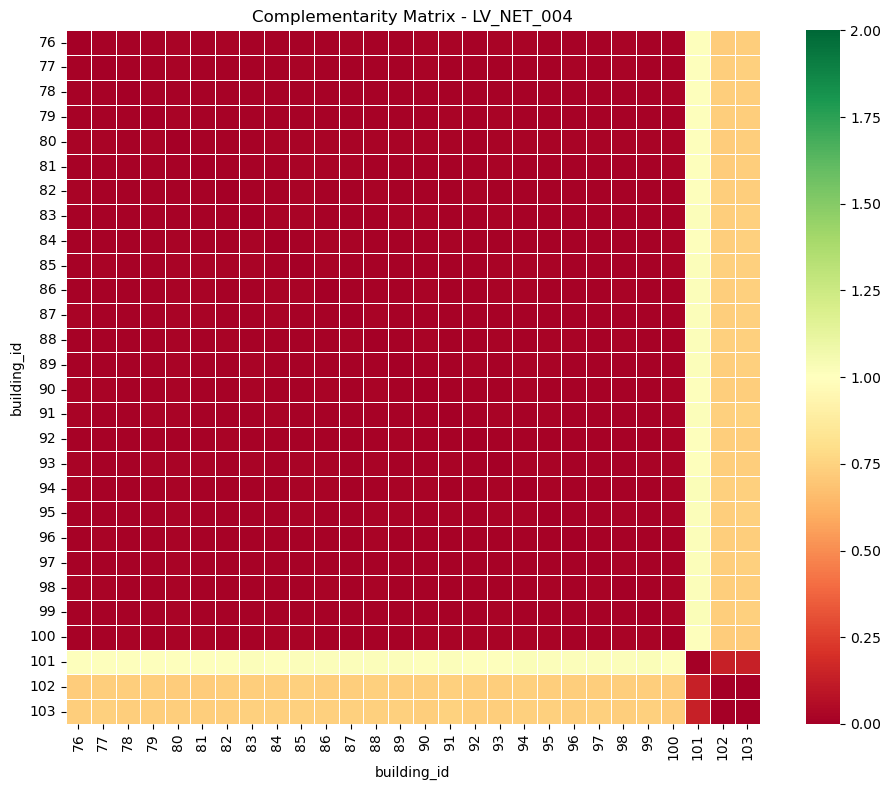

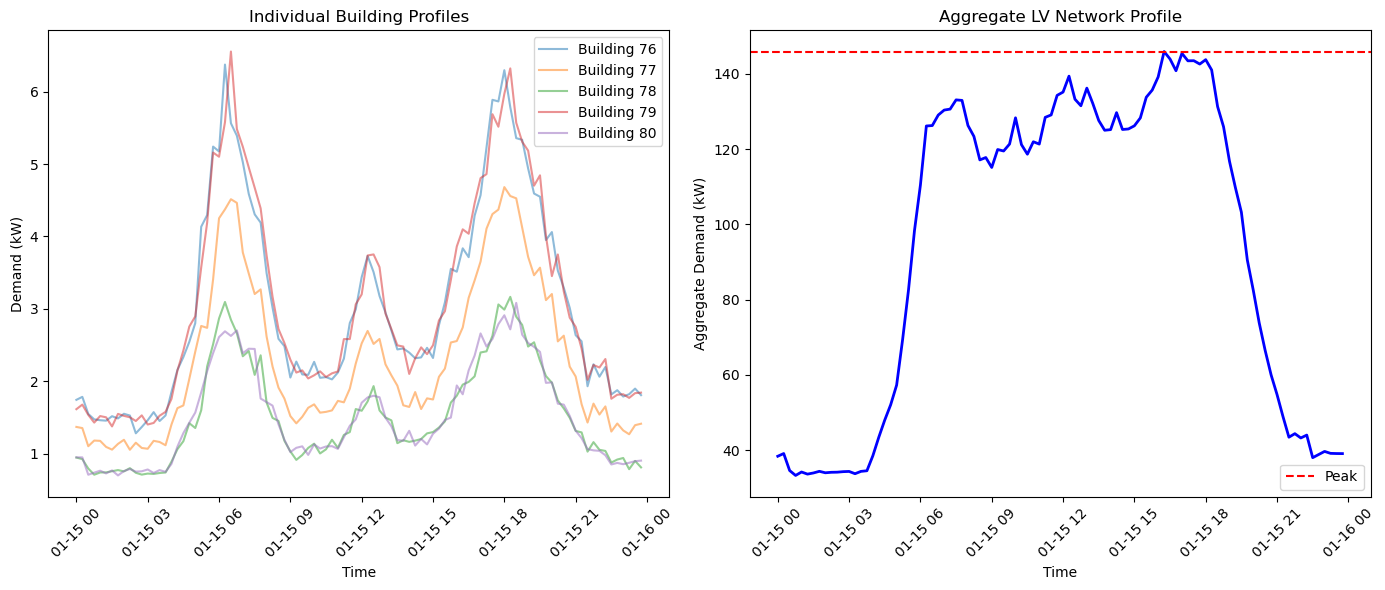


📊 Visualizations saved to mimic_data/


In [2]:
# analysis_pipeline.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

# Load the mimic data
buildings_df = pd.read_csv('mimic_data/buildings.csv')
profiles_df = pd.read_parquet('mimic_data/energy_profiles.parquet')
lv_networks_df = pd.read_csv('mimic_data/lv_networks.csv')

# ============================================
# COMPLEMENTARITY ANALYSIS
# ============================================

def calculate_complementarity_matrix(profiles_df, lv_network_id, time_window='all'):
    """Calculate pairwise complementarity for buildings in an LV network"""
    
    # Get buildings in this LV network
    lv_buildings = buildings_df[buildings_df['lv_network_id'] == lv_network_id]['ogc_fid'].values
    
    # Filter profiles
    lv_profiles = profiles_df[profiles_df['building_id'].isin(lv_buildings)]
    
    # Pivot to get time series per building
    demand_matrix = lv_profiles.pivot(
        index='timestamp', 
        columns='building_id', 
        values='electricity_demand_kw'
    ).fillna(0)
    
    # Calculate correlation matrix (negative correlation = complementary)
    corr_matrix = demand_matrix.corr()
    
    # Convert to complementarity (1 - correlation)
    complementarity_matrix = 1 - corr_matrix
    
    return complementarity_matrix, demand_matrix

# Analyze complementarity for each LV network
results = []
for lv_id in buildings_df['lv_network_id'].unique():
    comp_matrix, demand_matrix = calculate_complementarity_matrix(profiles_df, lv_id)
    
    # Calculate metrics
    avg_complementarity = comp_matrix.values[np.triu_indices_from(comp_matrix.values, k=1)].mean()
    
    # Peak reduction potential
    individual_peaks = demand_matrix.max(axis=0).sum()
    aggregate_peak = demand_matrix.sum(axis=1).max()
    peak_reduction = 1 - (aggregate_peak / individual_peaks)
    
    results.append({
        'lv_network_id': lv_id,
        'avg_complementarity': avg_complementarity,
        'peak_reduction_potential': peak_reduction,
        'num_buildings': len(demand_matrix.columns)
    })

results_df = pd.DataFrame(results)
print("\n🎯 Complementarity Analysis Results:")
print(results_df.sort_values('peak_reduction_potential', ascending=False))

# ============================================
# IDENTIFY BEST DISTRICT
# ============================================

best_lv = results_df.loc[results_df['peak_reduction_potential'].idxmax(), 'lv_network_id']
print(f"\n✨ Best LV Network for pilot: {best_lv}")
print(f"   Peak reduction potential: {results_df.loc[results_df['lv_network_id']==best_lv, 'peak_reduction_potential'].values[0]:.1%}")

# ============================================
# VISUALIZE COMPLEMENTARITY
# ============================================

# Get the best LV network's data
comp_matrix, demand_matrix = calculate_complementarity_matrix(profiles_df, best_lv)

# Plot complementarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(comp_matrix, cmap='RdYlGn', center=1, vmin=0, vmax=2, 
            square=True, linewidths=0.5)
plt.title(f'Complementarity Matrix - {best_lv}')
plt.tight_layout()
plt.savefig('mimic_data/complementarity_heatmap.png')
plt.show()

# Plot aggregate vs individual peaks
plt.figure(figsize=(14, 6))

# Subplot 1: Individual profiles
plt.subplot(1, 2, 1)
for col in demand_matrix.columns[:5]:  # Plot first 5 buildings
    plt.plot(demand_matrix.index[:96], demand_matrix[col][:96], alpha=0.5, label=f'Building {col}')
plt.xlabel('Time')
plt.ylabel('Demand (kW)')
plt.title('Individual Building Profiles')
plt.legend()
plt.xticks(rotation=45)

# Subplot 2: Aggregate profile
plt.subplot(1, 2, 2)
aggregate = demand_matrix.sum(axis=1)
plt.plot(aggregate.index[:96], aggregate[:96], 'b-', linewidth=2)
plt.axhline(y=aggregate[:96].max(), color='r', linestyle='--', label='Peak')
plt.xlabel('Time')
plt.ylabel('Aggregate Demand (kW)')
plt.title('Aggregate LV Network Profile')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('mimic_data/demand_profiles.png')
plt.show()

print("\n📊 Visualizations saved to mimic_data/")

# NEO$J

In [2]:
from neo4j import GraphDatabase

# Test connection
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "aminasad"))
try:
    driver.verify_connectivity()
    print("✅ Connected to Neo4j successfully!")
except Exception as e:
    print(f"❌ Connection failed: {e}")
finally:
    driver.close()

✅ Connected to Neo4j successfully!


# Neo4j 

## 1

In [3]:
"""
Knowledge Graph Builder for Energy District Analysis - PRE-GNN VERSION
Creates the foundational KG with raw data, infrastructure, and potential
Complementarity and clustering will be added AFTER GNN analysis
"""

import pandas as pd
import numpy as np
from neo4j import GraphDatabase
from datetime import datetime, timedelta
import json
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class EnergyKnowledgeGraphBuilder:
    """Build Knowledge Graph from energy district data - Pre-GNN version"""
    
    def __init__(self, uri: str, user: str, password: str):
        """Initialize Neo4j connection"""
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.stats = {
            'nodes_created': {},
            'relationships_created': {},
            'processing_time': {}
        }
        logger.info(f"Connected to Neo4j at {uri}")
    
    def close(self):
        """Close database connection"""
        self.driver.close()
        logger.info("Neo4j connection closed")
    
    def clear_database(self):
        """Clear all nodes and relationships"""
        with self.driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")
            logger.info("Database cleared")
    
    # ============================================
    # STEP 1: SCHEMA SETUP
    # ============================================
    
    def create_schema(self):
        """Create constraints and indexes for pre-GNN KG"""
        logger.info("Creating schema constraints and indexes...")
        
        constraints = [
            # Infrastructure
            "CREATE CONSTRAINT IF NOT EXISTS FOR (s:Substation) REQUIRE s.id IS UNIQUE",
            "CREATE CONSTRAINT IF NOT EXISTS FOR (m:MV_Transformer) REQUIRE m.id IS UNIQUE",
            "CREATE CONSTRAINT IF NOT EXISTS FOR (l:LV_Network) REQUIRE l.component_id IS UNIQUE",
            "CREATE CONSTRAINT IF NOT EXISTS FOR (b:Building) REQUIRE b.ogc_fid IS UNIQUE",
            
            # Temporal
            "CREATE CONSTRAINT IF NOT EXISTS FOR (t:TimeSlot) REQUIRE t.slot_id IS UNIQUE",
            "CREATE CONSTRAINT IF NOT EXISTS FOR (e:EnergyState) REQUIRE e.state_id IS UNIQUE",
            
            # Assets
            "CREATE CONSTRAINT IF NOT EXISTS FOR (sol:SolarSystem) REQUIRE sol.system_id IS UNIQUE",
            "CREATE CONSTRAINT IF NOT EXISTS FOR (bat:BatterySystem) REQUIRE bat.system_id IS UNIQUE",
            "CREATE CONSTRAINT IF NOT EXISTS FOR (hp:HeatPumpSystem) REQUIRE hp.system_id IS UNIQUE",
        ]
        
        indexes = [
            # Performance indexes
            "CREATE INDEX IF NOT EXISTS FOR (b:Building) ON (b.lv_component_id)",
            "CREATE INDEX IF NOT EXISTS FOR (b:Building) ON (b.building_function)",
            "CREATE INDEX IF NOT EXISTS FOR (b:Building) ON (b.has_solar)",
            "CREATE INDEX IF NOT EXISTS FOR (t:TimeSlot) ON (t.timestamp)",
            "CREATE INDEX IF NOT EXISTS FOR (t:TimeSlot) ON (t.hour_of_day)",
            "CREATE INDEX IF NOT EXISTS FOR (e:EnergyState) ON (e.building_id)",
            "CREATE INDEX IF NOT EXISTS FOR (e:EnergyState) ON (e.timeslot_id)",
        ]
        
        with self.driver.session() as session:
            for constraint in constraints:
                session.run(constraint)
            for index in indexes:
                session.run(index)
        
        logger.info("Schema created successfully")
    
    # ============================================
    # STEP 2: LOAD GRID INFRASTRUCTURE
    # ============================================
    
    def load_grid_infrastructure(self, data_path: str):
        """Load grid topology: Substation -> MV -> LV hierarchy"""
        logger.info("Loading grid infrastructure...")
        
        # Load data files
        lv_networks = pd.read_csv(f"{data_path}/lv_networks.csv")
        mv_transformers = pd.read_csv(f"{data_path}/mv_transformers.csv")
        
        with self.driver.session() as session:
            # Create Substation
            session.run("""
                CREATE (s:Substation {
                    id: 'SUB_001',
                    name: 'Main Substation',
                    x: 100000,
                    y: 450000,
                    capacity_mva: 50,
                    voltage_level: 'HV'
                })
            """)
            self.stats['nodes_created']['Substation'] = 1
            
            # Create MV Transformers
            for _, mv in mv_transformers.iterrows():
                session.run("""
                    CREATE (m:MV_Transformer {
                        id: $id,
                        x: $x,
                        y: $y,
                        capacity_kva: $capacity,
                        substation_id: $sub_id,
                        voltage_level: 'MV'
                    })
                """, 
                id=mv['id'],
                x=float(mv['x']),
                y=float(mv['y']),
                capacity=float(mv['capacity_kva']),
                sub_id=mv['substation_id']
                )
            self.stats['nodes_created']['MV_Transformer'] = len(mv_transformers)
            
            # Create LV Networks
            for _, lv in lv_networks.iterrows():
                session.run("""
                    CREATE (l:LV_Network {
                        component_id: $comp_id,
                        network_id: $net_id,
                        x: $x,
                        y: $y,
                        mv_transformer_id: $mv_id,
                        capacity_kva: $capacity,
                        voltage_level: 'LV'
                    })
                """,
                comp_id=int(lv['component_id']),
                net_id=lv['id'],
                x=float(lv['x']),
                y=float(lv['y']),
                mv_id=lv['mv_transformer_id'],
                capacity=float(lv['capacity_kva'])
                )
            self.stats['nodes_created']['LV_Network'] = len(lv_networks)
            
            # Create hierarchy relationships
            # MV Transformers -> Substation
            session.run("""
                MATCH (m:MV_Transformer), (s:Substation {id: m.substation_id})
                CREATE (m)-[:FEEDS_FROM {capacity_kva: m.capacity_kva}]->(s)
            """)
            
            # LV Networks -> MV Transformers
            result = session.run("""
                MATCH (l:LV_Network), (m:MV_Transformer {id: l.mv_transformer_id})
                CREATE (l)-[:FEEDS_FROM {capacity_kva: l.capacity_kva}]->(m)
                RETURN count(*) as count
            """)
            
            self.stats['relationships_created']['FEEDS_FROM'] = result.single()['count'] + len(mv_transformers)
            
        logger.info(f"Created {sum(self.stats['nodes_created'].values())} infrastructure nodes")
    
    # ============================================
    # STEP 3: LOAD AND ENHANCE BUILDINGS
    # ============================================
    
    def load_buildings(self, data_path: str):
        """Load buildings with derived features"""
        logger.info("Loading building data...")
        
        buildings = pd.read_csv(f"{data_path}/buildings.csv")
        
        # Add derived features
        buildings = self._calculate_building_features(buildings)
        
        with self.driver.session() as session:
            for _, building in buildings.iterrows():
                # Create building node with all features
                session.run("""
                    CREATE (b:Building {
                        ogc_fid: $ogc_fid,
                        x: $x,
                        y: $y,
                        building_function: $function,
                        residential_type: $res_type,
                        non_residential_type: $non_res_type,
                        area: $area,
                        height: $height,
                        age_range: $age,
                        building_orientation_cardinal: $orientation,
                        roof_area: $roof_area,
                        flat_roof_area: $flat_roof,
                        sloped_roof_area: $sloped_roof,
                        suitable_roof_area: $suitable_roof,
                        lv_component_id: $lv_id,
                        lv_network_id: $lv_net_id,
                        
                        // Derived features
                        energy_label: $energy_label,
                        insulation_quality: $insulation,
                        solar_potential: $solar_pot,
                        solar_capacity_kwp: $solar_kwp,
                        battery_readiness: $battery_ready,
                        electrification_feasibility: $elec_feasible,
                        expected_cop: $cop,
                        
                        // Current assets
                        has_solar: $has_solar,
                        has_battery: $has_battery,
                        has_heat_pump: $has_hp,
                        heating_system: $heating
                    })
                """,
                ogc_fid=int(building['ogc_fid']),
                x=float(building['x']),
                y=float(building['y']),
                function=building['building_function'],
                res_type=building['residential_type'] if pd.notna(building['residential_type']) else 'None',
                non_res_type=building['non_residential_type'] if pd.notna(building['non_residential_type']) else 'None',
                area=float(building['area']),
                height=float(building['height']),
                age=building['age_range'],
                orientation=building['building_orientation_cardinal'],
                roof_area=float(building['roof_area']),
                flat_roof=float(building['flat_roof_area']),
                sloped_roof=float(building['sloped_roof_area']),
                suitable_roof=float(building['suitable_roof_area']),
                lv_id=int(building['lv_component_id']),
                lv_net_id=building['lv_network_id'],
                energy_label=building['energy_label'],
                insulation=building['insulation_quality'],
                solar_pot=building['solar_potential'],
                solar_kwp=float(building['solar_capacity_kwp']),
                battery_ready=building['battery_readiness'],
                elec_feasible=building['electrification_feasibility'],
                cop=float(building['expected_cop']),
                has_solar=bool(building['has_solar']),
                has_battery=bool(building['has_battery']),
                has_hp=bool(building['has_heat_pump']),
                heating=building['heating_system']
                )
            
            # Create CONNECTED_TO relationships
            result = session.run("""
                MATCH (b:Building), (l:LV_Network {component_id: b.lv_component_id})
                WITH b, l, 
                     sqrt((b.x - l.x)^2 + (b.y - l.y)^2) as distance
                CREATE (b)-[:CONNECTED_TO {
                    distance_m: distance,
                    cable_type: 'underground'
                }]->(l)
                RETURN count(*) as count
            """)
            
            self.stats['nodes_created']['Building'] = len(buildings)
            self.stats['relationships_created']['CONNECTED_TO'] = result.single()['count']
            
        logger.info(f"Created {len(buildings)} building nodes with enhanced features")
    
    def _calculate_building_features(self, buildings: pd.DataFrame) -> pd.DataFrame:
        """Calculate derived building features"""
        
        # Energy label based on age and type
        def get_energy_label(row):
            age_labels = {
                '<1945': 'F',
                '1945-1975': 'E',
                '1975-1995': 'D',
                '1995-2015': 'C',
                '>2015': 'B'
            }
            base_label = age_labels.get(row['age_range'], 'D')
            
            # Adjust for building type
            if row['building_function'] == 'non_residential':
                if row['non_residential_type'] == 'Office' and row['age_range'] == '>2015':
                    return 'A'
            return base_label
        
        buildings['energy_label'] = buildings.apply(get_energy_label, axis=1)
        
        # Insulation quality
        label_insulation = {
            'A': 'excellent', 'B': 'good', 'C': 'good',
            'D': 'fair', 'E': 'fair', 'F': 'poor', 'G': 'poor'
        }
        buildings['insulation_quality'] = buildings['energy_label'].map(label_insulation)
        
        # Solar potential calculation
        buildings['suitable_roof_area'] = buildings['flat_roof_area'] + \
            buildings.apply(lambda x: x['sloped_roof_area'] * 0.6 
                          if x['building_orientation_cardinal'] in ['S', 'SE', 'SW'] 
                          else x['sloped_roof_area'] * 0.3, axis=1)
        
        def get_solar_potential(row):
            if row['suitable_roof_area'] > 100:
                return 'high'
            elif row['suitable_roof_area'] > 50:
                return 'medium'
            elif row['suitable_roof_area'] > 25:
                return 'low'
            else:
                return 'none'
        
        buildings['solar_potential'] = buildings.apply(get_solar_potential, axis=1)
        buildings['solar_capacity_kwp'] = buildings['suitable_roof_area'] * 0.15 * 0.7
        
        # Battery readiness
        buildings['battery_readiness'] = buildings['solar_potential'].apply(
            lambda x: 'ready' if x in ['high', 'medium'] else 'conditional'
        )
        
        # Electrification feasibility
        def get_electrification_feasibility(row):
            if row['energy_label'] in ['F', 'G']:
                return 'upgrade_needed'
            elif row['energy_label'] in ['D', 'E']:
                return 'conditional'
            else:
                return 'immediate'
        
        buildings['electrification_feasibility'] = buildings.apply(get_electrification_feasibility, axis=1)
        
        # Expected COP for heat pumps
        cop_by_label = {
            'A': 4.0, 'B': 3.5, 'C': 3.0,
            'D': 2.5, 'E': 2.0, 'F': 1.8, 'G': 1.5
        }
        buildings['expected_cop'] = buildings['energy_label'].map(cop_by_label)
        
        # Current assets (simplified assumptions for demo)
        np.random.seed(42)  # For reproducibility
        buildings['has_solar'] = (buildings['solar_capacity_kwp'] > 5) & (np.random.random(len(buildings)) > 0.7)
        buildings['has_battery'] = buildings['has_solar'] & (np.random.random(len(buildings)) > 0.5)
        buildings['has_heat_pump'] = (buildings['energy_label'].isin(['A', 'B'])) & (np.random.random(len(buildings)) > 0.6)
        buildings['heating_system'] = buildings.apply(
            lambda x: 'heat_pump' if x['has_heat_pump'] else 'gas', axis=1
        )
        
        return buildings
    
    # ============================================
    # STEP 4: CREATE EXISTING ASSET NODES
    # ============================================
    
    def create_existing_assets(self):
        """Create asset nodes for buildings that already have installations"""
        logger.info("Creating existing asset nodes...")
        
        with self.driver.session() as session:
            # Existing solar systems
            result = session.run("""
                MATCH (b:Building {has_solar: true})
                CREATE (s:SolarSystem {
                    system_id: 'SOLAR_EXISTING_' + toString(b.ogc_fid),
                    building_id: b.ogc_fid,
                    status: 'existing',
                    installed_capacity_kwp: b.solar_capacity_kwp,
                    installation_year: 2023,
                    degradation_factor: 0.98,
                    orientation_efficiency: 
                        CASE b.building_orientation_cardinal
                            WHEN 'S' THEN 1.0
                            WHEN 'SE' THEN 0.95
                            WHEN 'SW' THEN 0.95
                            ELSE 0.8
                        END
                })
                CREATE (b)-[:HAS_INSTALLED {
                    install_date: date('2023-01-01')
                }]->(s)
                RETURN count(*) as count
            """)
            solar_count = result.single()['count']
            
            # Existing battery systems
            result = session.run("""
                MATCH (b:Building {has_battery: true})
                CREATE (bat:BatterySystem {
                    system_id: 'BATTERY_EXISTING_' + toString(b.ogc_fid),
                    building_id: b.ogc_fid,
                    status: 'existing',
                    installed_capacity_kwh: 
                        CASE 
                            WHEN b.area < 150 THEN 5.0
                            WHEN b.area < 300 THEN 10.0
                            ELSE 15.0
                        END,
                    power_rating_kw: 
                        CASE 
                            WHEN b.area < 150 THEN 2.5
                            WHEN b.area < 300 THEN 5.0
                            ELSE 7.5
                        END,
                    round_trip_efficiency: 0.9
                })
                CREATE (b)-[:HAS_INSTALLED {
                    install_date: date('2023-01-01')
                }]->(bat)
                RETURN count(*) as count
            """)
            battery_count = result.single()['count']
            
            # Existing heat pump systems
            result = session.run("""
                MATCH (b:Building {has_heat_pump: true})
                CREATE (hp:HeatPumpSystem {
                    system_id: 'HP_EXISTING_' + toString(b.ogc_fid),
                    building_id: b.ogc_fid,
                    status: 'existing',
                    expected_cop: b.expected_cop,
                    heating_capacity_kw: b.area * 0.05,
                    installation_year: 2022
                })
                CREATE (b)-[:HAS_INSTALLED {
                    install_date: date('2022-01-01')
                }]->(hp)
                RETURN count(*) as count
            """)
            hp_count = result.single()['count']
            
            self.stats['nodes_created']['ExistingSolar'] = solar_count
            self.stats['nodes_created']['ExistingBattery'] = battery_count
            self.stats['nodes_created']['ExistingHeatPump'] = hp_count
            self.stats['relationships_created']['HAS_INSTALLED'] = solar_count + battery_count + hp_count
            
        logger.info(f"Created existing assets: {solar_count} solar, {battery_count} battery, {hp_count} heat pumps")
    
    # ============================================
    # STEP 5: LOAD TEMPORAL ENERGY DATA
    # ============================================
    
    def load_temporal_data(self, data_path: str):
        """Load time-series energy profiles"""
        logger.info("Loading temporal energy data...")
        
        # Load energy profiles
        profiles = pd.read_parquet(f"{data_path}/energy_profiles.parquet")
        
        # Get unique timestamps
        timestamps = profiles['timestamp'].unique()
        
        with self.driver.session() as session:
            # Create TimeSlot nodes
            for i, ts in enumerate(timestamps):
                dt = pd.to_datetime(ts)
                session.run("""
                    CREATE (t:TimeSlot {
                        slot_id: $slot_id,
                        timestamp: datetime($timestamp),
                        hour_of_day: $hour,
                        day_of_week: $dow,
                        is_weekend: $weekend,
                        season: $season,
                        time_of_day: $tod
                    })
                """,
                slot_id=f"TS_{i}",
                timestamp=dt.isoformat(),
                hour=dt.hour,
                dow=dt.dayofweek,
                weekend=dt.dayofweek >= 5,
                season=self._get_season(dt),
                tod=self._get_time_of_day(dt.hour)
                )
            
            self.stats['nodes_created']['TimeSlot'] = len(timestamps)
            
            # Create EnergyState nodes in batches
            logger.info("Creating energy states (this may take a moment)...")
            
            batch_size = 1000
            state_count = 0
            
            for building_id in profiles['building_id'].unique():
                building_data = profiles[profiles['building_id'] == building_id]
                
                states = []
                for idx, row in building_data.iterrows():
                    dt = pd.to_datetime(row['timestamp'])
                    slot_id = f"TS_{list(timestamps).index(row['timestamp'])}"
                    
                    # Calculate net position
                    net_demand = row['electricity_demand_kw'] - row['solar_generation_kw'] + row['battery_discharge_kw'] - row['battery_charge_kw']
                    
                    states.append({
                        'state_id': f"ES_{building_id}_{slot_id}",
                        'building_id': int(building_id),
                        'timeslot_id': slot_id,
                        'electricity_demand_kw': float(row['electricity_demand_kw']),
                        'heating_demand_kw': float(row['heating_demand_kw']),
                        'cooling_demand_kw': float(row['cooling_demand_kw']),
                        'solar_generation_kw': float(row['solar_generation_kw']),
                        'battery_soc_kwh': float(row['battery_soc_kwh']),
                        'battery_charge_kw': float(row['battery_charge_kw']),
                        'battery_discharge_kw': float(row['battery_discharge_kw']),
                        'net_demand_kw': float(net_demand),
                        'is_surplus': net_demand < 0,
                        'export_potential_kw': max(0, -net_demand),
                        'import_need_kw': max(0, net_demand)
                    })
                    
                    if len(states) >= batch_size:
                        self._create_energy_states_batch(session, states)
                        state_count += len(states)
                        states = []
                
                if states:
                    self._create_energy_states_batch(session, states)
                    state_count += len(states)
            
            self.stats['nodes_created']['EnergyState'] = state_count
            
            # Create relationships
            logger.info("Creating temporal relationships...")
            
            # Building -> EnergyState
            result = session.run("""
                MATCH (b:Building), (e:EnergyState {building_id: b.ogc_fid})
                CREATE (b)-[:HAS_STATE_AT]->(e)
                RETURN count(*) as count
            """)
            self.stats['relationships_created']['HAS_STATE_AT'] = result.single()['count']
            
            # EnergyState -> TimeSlot
            result = session.run("""
                MATCH (e:EnergyState), (t:TimeSlot {slot_id: e.timeslot_id})
                CREATE (e)-[:DURING]->(t)
                RETURN count(*) as count
            """)
            self.stats['relationships_created']['DURING'] = result.single()['count']
            
        logger.info(f"Created {state_count} energy states with temporal relationships")
    
    def _create_energy_states_batch(self, session, states):
        """Create energy state nodes in batch"""
        session.run("""
            UNWIND $states as state
            CREATE (e:EnergyState {
                state_id: state.state_id,
                building_id: state.building_id,
                timeslot_id: state.timeslot_id,
                electricity_demand_kw: state.electricity_demand_kw,
                heating_demand_kw: state.heating_demand_kw,
                cooling_demand_kw: state.cooling_demand_kw,
                solar_generation_kw: state.solar_generation_kw,
                battery_soc_kwh: state.battery_soc_kwh,
                battery_charge_kw: state.battery_charge_kw,
                battery_discharge_kw: state.battery_discharge_kw,
                net_demand_kw: state.net_demand_kw,
                is_surplus: state.is_surplus,
                export_potential_kw: state.export_potential_kw,
                import_need_kw: state.import_need_kw
            })
        """, states=states)
    
    def _get_season(self, dt):
        """Get season from datetime"""
        month = dt.month
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'fall'
    
    def _get_time_of_day(self, hour):
        """Categorize time of day"""
        if 6 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 18:
            return 'afternoon'
        elif 18 <= hour < 22:
            return 'evening'
        else:
            return 'night'
    
    # ============================================
    # STEP 6: IDENTIFY ASSET OPPORTUNITIES
    # ============================================
    
    def identify_asset_opportunities(self):
        """Create nodes for potential solar, battery, and electrification"""
        logger.info("Identifying asset deployment opportunities...")
        
        with self.driver.session() as session:
            # Solar opportunities (for buildings without solar)
            result = session.run("""
                MATCH (b:Building)
                WHERE b.solar_potential IN ['high', 'medium']
                  AND b.has_solar = false
                CREATE (s:SolarSystem {
                    system_id: 'SOLAR_POTENTIAL_' + toString(b.ogc_fid),
                    building_id: b.ogc_fid,
                    status: 'potential',
                    potential_capacity_kwp: b.solar_capacity_kwp,
                    recommended_capacity_kwp: 
                        CASE 
                            WHEN b.area < 150 THEN 4.0
                            WHEN b.area < 300 THEN 6.0
                            ELSE 10.0
                        END,
                    orientation_efficiency: 
                        CASE b.building_orientation_cardinal
                            WHEN 'S' THEN 1.0
                            WHEN 'SE' THEN 0.95
                            WHEN 'SW' THEN 0.95
                            WHEN 'E' THEN 0.85
                            WHEN 'W' THEN 0.85
                            ELSE 0.7
                        END,
                    payback_years: 7.5
                })
                CREATE (b)-[:CAN_INSTALL {
                    feasibility_score: 
                        CASE b.solar_potential
                            WHEN 'high' THEN 0.9
                            WHEN 'medium' THEN 0.7
                            ELSE 0.5
                        END,
                    priority: 'medium'
                }]->(s)
                RETURN count(*) as count
            """)
            
            solar_count = result.single()['count']
            self.stats['nodes_created']['SolarPotential'] = solar_count
            
            # Battery opportunities
            result = session.run("""
                MATCH (b:Building)
                WHERE (b.solar_potential IN ['high', 'medium'] OR b.building_function = 'non_residential')
                  AND b.has_battery = false
                WITH b, 
                     CASE 
                         WHEN b.area < 150 THEN 5.0
                         WHEN b.area < 300 THEN 10.0
                         ELSE 20.0
                     END as battery_size
                CREATE (bat:BatterySystem {
                    system_id: 'BATTERY_POTENTIAL_' + toString(b.ogc_fid),
                    building_id: b.ogc_fid,
                    status: 'potential',
                    recommended_capacity_kwh: battery_size,
                    power_rating_kw: battery_size / 4,
                    round_trip_efficiency: 0.9,
                    estimated_cycles_per_year: 250
                })
                CREATE (b)-[:CAN_INSTALL {
                    feasibility_score: 
                        CASE 
                            WHEN b.has_solar OR b.solar_potential IN ['high', 'medium'] THEN 0.8
                            ELSE 0.6
                        END,
                    requires_solar: NOT b.has_solar,
                    priority: 'low'
                }]->(bat)
                RETURN count(*) as count
            """)
            
            battery_count = result.single()['count']
            self.stats['nodes_created']['BatteryPotential'] = battery_count
            
            # Electrification opportunities (heat pumps for poor efficiency buildings)
            result = session.run("""
                MATCH (b:Building)
                WHERE b.energy_label IN ['D', 'E', 'F', 'G']
                  AND b.has_heat_pump = false
                CREATE (hp:HeatPumpSystem {
                    system_id: 'HP_POTENTIAL_' + toString(b.ogc_fid),
                    building_id: b.ogc_fid,
                    status: 'potential',
                    expected_cop: b.expected_cop,
                    heating_capacity_kw: b.area * 0.05,
                    upgrade_required: b.electrification_feasibility = 'upgrade_needed',
                    estimated_annual_savings_euro: 
                        CASE b.energy_label
                            WHEN 'G' THEN 2000
                            WHEN 'F' THEN 1500
                            WHEN 'E' THEN 1000
                            ELSE 500
                        END
                })
                CREATE (b)-[:SHOULD_ELECTRIFY {
                    priority: 
                        CASE b.energy_label
                            WHEN 'G' THEN 1
                            WHEN 'F' THEN 2
                            WHEN 'E' THEN 3
                            WHEN 'D' THEN 4
                            ELSE 5
                        END,
                    expected_cop: b.expected_cop,
                    requires_insulation_upgrade: b.energy_label IN ['F', 'G']
                }]->(hp)
                RETURN count(*) as count
            """)
            
            hp_count = result.single()['count']
            self.stats['nodes_created']['HeatPumpPotential'] = hp_count
            
        logger.info(f"Identified opportunities: {solar_count} solar, {battery_count} battery, {hp_count} heat pumps")
    
    # ============================================
    # STEP 7: CALCULATE BASELINE METRICS
    # ============================================
    
    def calculate_baseline_metrics(self):
        """Calculate current state metrics for comparison after GNN optimization"""
        logger.info("Calculating baseline metrics...")
        
        with self.driver.session() as session:
            # Building-level statistics
            session.run("""
                MATCH (b:Building)-[:HAS_STATE_AT]->(e:EnergyState)
                WITH b, 
                    max(e.electricity_demand_kw) as peak_demand,
                    avg(e.electricity_demand_kw) as avg_demand,
                    stdev(e.electricity_demand_kw) as demand_std,
                    max(e.solar_generation_kw) as peak_solar,
                    avg(e.net_demand_kw) as avg_net_demand
                SET b.peak_demand_kw = peak_demand,
                    b.avg_demand_kw = avg_demand,
                    b.load_factor = avg_demand / CASE WHEN peak_demand > 0 THEN peak_demand ELSE 1 END,
                    b.demand_variability = demand_std / CASE WHEN avg_demand > 0 THEN avg_demand ELSE 1 END,
                    b.peak_solar_kw = peak_solar,
                    b.avg_net_demand_kw = avg_net_demand,
                    b.self_consumption_ratio = 
                        CASE WHEN b.has_solar 
                        THEN (avg_demand - avg_net_demand) / CASE WHEN avg_demand > 0 THEN avg_demand ELSE 1 END
                        ELSE 0 END
            """)
            
            # LV Network baseline statistics
            session.run("""
                MATCH (l:LV_Network)<-[:CONNECTED_TO]-(b:Building)
                WITH l, 
                    count(b) as building_count,
                    sum(b.peak_demand_kw) as total_peak_demand,
                    avg(b.peak_demand_kw) as avg_building_peak,
                    sum(b.avg_demand_kw) as total_avg_demand,
                    sum(CASE WHEN b.has_solar THEN 1 ELSE 0 END) as solar_count,
                    sum(CASE WHEN b.has_battery THEN 1 ELSE 0 END) as battery_count,
                    sum(CASE WHEN b.has_heat_pump THEN 1 ELSE 0 END) as hp_count,
                    collect(DISTINCT b.building_function) as building_types
                SET l.baseline_building_count = building_count,
                    l.baseline_peak_kw = total_peak_demand,
                    l.baseline_avg_demand_kw = total_avg_demand,
                    l.baseline_load_factor = total_avg_demand / CASE WHEN total_peak_demand > 0 THEN total_peak_demand ELSE 1 END,
                    l.baseline_solar_penetration = toFloat(solar_count) / building_count,
                    l.baseline_battery_penetration = toFloat(battery_count) / building_count,
                    l.baseline_hp_penetration = toFloat(hp_count) / building_count,
                    l.baseline_diversity = size(building_types),
                    l.baseline_self_sufficiency = 0.1  // Placeholder - will be calculated properly
            """)
            
            # Calculate peak coincidence factor - FIXED VERSION
            session.run("""
                MATCH (l:LV_Network)<-[:CONNECTED_TO]-(b:Building)
                WITH l, sum(b.peak_demand_kw) as sum_of_peaks
                MATCH (l)<-[:CONNECTED_TO]-(b2:Building)-[:HAS_STATE_AT]->(e:EnergyState)-[:DURING]->(t:TimeSlot)
                WITH l, sum_of_peaks, t, sum(e.electricity_demand_kw) as total_demand_at_time
                WITH l, sum_of_peaks, max(total_demand_at_time) as actual_peak
                SET l.baseline_coincidence_factor = actual_peak / CASE WHEN sum_of_peaks > 0 THEN sum_of_peaks ELSE 1 END
            """)
            
            # MV Transformer baseline
            session.run("""
                MATCH (m:MV_Transformer)<-[:FEEDS_FROM]-(l:LV_Network)
                WITH m, 
                    count(l) as lv_count,
                    sum(l.baseline_peak_kw) as total_peak,
                    sum(l.baseline_building_count) as total_buildings
                SET m.baseline_lv_count = lv_count,
                    m.baseline_peak_kw = total_peak,
                    m.baseline_utilization = total_peak / m.capacity_kva,
                    m.baseline_building_count = total_buildings
            """)
            
            # System-wide baseline
            result = session.run("""
                MATCH (b:Building)
                WITH count(b) as total_buildings,
                    sum(b.peak_demand_kw) as system_peak,
                    avg(b.load_factor) as avg_load_factor,
                    sum(CASE WHEN b.has_solar THEN 1 ELSE 0 END) as solar_buildings,
                    sum(CASE WHEN b.has_battery THEN 1 ELSE 0 END) as battery_buildings,
                    sum(CASE WHEN b.has_heat_pump THEN 1 ELSE 0 END) as hp_buildings
                CREATE (s:SystemBaseline {
                    id: 'BASELINE_' + toString(datetime()),
                    timestamp: datetime(),
                    total_buildings: total_buildings,
                    system_peak_kw: system_peak,
                    avg_load_factor: avg_load_factor,
                    solar_penetration: toFloat(solar_buildings) / total_buildings,
                    battery_penetration: toFloat(battery_buildings) / total_buildings,
                    hp_penetration: toFloat(hp_buildings) / total_buildings,
                    description: 'Pre-GNN optimization baseline'
                })
                RETURN total_buildings, system_peak, avg_load_factor
            """)
            
            baseline = result.single()
            logger.info(f"Baseline: {baseline['total_buildings']} buildings, "
                    f"{baseline['system_peak']:.0f} kW peak, "
                    f"{baseline['avg_load_factor']:.3f} load factor")
            
    # ============================================
    # STEP 8: ADD METADATA
    # ============================================
    
    def add_metadata(self):
        """Add metadata about the KG creation"""
        logger.info("Adding metadata...")
        
        with self.driver.session() as session:
            metadata = {
                'creation_timestamp': datetime.now().isoformat(),
                'total_nodes': sum(self.stats['nodes_created'].values()),
                'total_relationships': sum(self.stats['relationships_created'].values()),
                'node_types': self.stats['nodes_created'],
                'relationship_types': self.stats['relationships_created']
            }
            
            session.run("""
                CREATE (m:Metadata {
                    id: 'PRE_GNN_METADATA',
                    created_at: datetime($timestamp),
                    total_nodes: $nodes,
                    total_relationships: $rels,
                    node_breakdown: $node_types,
                    relationship_breakdown: $rel_types,
                    data_quality: 'mimic_data',
                    version: '1.0',
                    stage: 'pre_gnn',
                    description: 'Knowledge graph before GNN optimization'
                })
            """,
            timestamp=metadata['creation_timestamp'],
            nodes=metadata['total_nodes'],
            rels=metadata['total_relationships'],
            node_types=json.dumps(metadata['node_types']),
            rel_types=json.dumps(metadata['relationship_types'])
            )
            
        logger.info("Metadata added")
    
    # ============================================
    # MAIN EXECUTION METHOD
    # ============================================
    
    def build_complete_graph(self, data_path: str, clear_first: bool = True):
        """Build complete knowledge graph from mimic data (Pre-GNN version)"""
        
        start_time = datetime.now()
        logger.info("="*50)
        logger.info("Starting Knowledge Graph Construction (Pre-GNN)")
        logger.info("="*50)
        
        try:
            # Clear database if requested
            if clear_first:
                self.clear_database()
            
            # Build graph step by step
            self.create_schema()
            self.load_grid_infrastructure(data_path)
            self.load_buildings(data_path)
            self.create_existing_assets()
            self.load_temporal_data(data_path)
            self.identify_asset_opportunities()
            self.calculate_baseline_metrics()
            self.add_metadata()
            
            # Calculate total time
            end_time = datetime.now()
            total_time = (end_time - start_time).total_seconds()
            
            # Print summary
            logger.info("="*50)
            logger.info("Pre-GNN Knowledge Graph Construction Complete!")
            logger.info("="*50)
            logger.info(f"Total processing time: {total_time:.2f} seconds")
            logger.info("\nNodes created:")
            for node_type, count in self.stats['nodes_created'].items():
                logger.info(f"  {node_type}: {count:,}")
            logger.info(f"  TOTAL: {sum(self.stats['nodes_created'].values()):,}")
            
            logger.info("\nRelationships created:")
            for rel_type, count in self.stats['relationships_created'].items():
                logger.info(f"  {rel_type}: {count:,}")
            logger.info(f"  TOTAL: {sum(self.stats['relationships_created'].values()):,}")
            
            logger.info("\n⚠️ Note: Complementarity analysis and clustering will be added after GNN processing")
            
            return self.stats
            
        except Exception as e:
            logger.error(f"Error building knowledge graph: {str(e)}")
            raise

# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    # Configuration
    NEO4J_URI = "bolt://localhost:7687"
    NEO4J_USER = "neo4j"
    NEO4J_PASSWORD = "aminasad"  # Change this to your password
    DATA_PATH = "mimic_data"
    
    # Create builder and construct graph
    builder = EnergyKnowledgeGraphBuilder(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
    
    try:
        # Build complete knowledge graph
        stats = builder.build_complete_graph(DATA_PATH, clear_first=True)
        
        # Run validation queries
        with builder.driver.session() as session:
            # Check baseline metrics
            result = session.run("""
                MATCH (l:LV_Network)
                RETURN l.network_id as lv_network,
                       l.baseline_building_count as buildings,
                       l.baseline_peak_kw as peak_kw,
                       l.baseline_load_factor as load_factor,
                       l.baseline_solar_penetration as solar_pen
                ORDER BY buildings DESC
            """)
            
            print("\n" + "="*50)
            print("LV Network Baseline Summary:")
            print("="*50)
            for record in result:
                print(f"{record['lv_network']}: {record['buildings']} buildings, "
                      f"Peak: {record['peak_kw']:.0f} kW, "
                      f"LF: {record['load_factor']:.2f}, "
                      f"Solar: {record['solar_pen']:.1%}")
            
            # Check opportunities
            result = session.run("""
                MATCH (s:SolarSystem {status: 'potential'})
                WITH count(s) as solar_opp
                MATCH (b:BatterySystem {status: 'potential'})
                WITH solar_opp, count(b) as battery_opp
                MATCH (h:HeatPumpSystem {status: 'potential'})
                RETURN solar_opp, battery_opp, count(h) as hp_opp
            """)
            
            opp = result.single()
            print("\n" + "="*50)
            print("Deployment Opportunities Identified:")
            print("="*50)
            print(f"Solar: {opp['solar_opp']} buildings")
            print(f"Battery: {opp['battery_opp']} buildings")
            print(f"Heat Pump: {opp['hp_opp']} buildings")
        
    finally:
        builder.close()
    
    print("\n✅ Pre-GNN Knowledge Graph construction complete!")
    print("Ready for GNN processing to discover complementarity and optimal clustering")
    print("You can explore the graph in Neo4j Browser at http://localhost:7474")

2025-08-16 00:21:13,302 - INFO - Connected to Neo4j at bolt://localhost:7687
2025-08-16 00:21:13,303 - INFO - ==================================================
2025-08-16 00:21:13,304 - INFO - Starting Knowledge Graph Construction (Pre-GNN)
2025-08-16 00:21:13,304 - INFO - ==================================================
2025-08-16 00:21:19,324 - INFO - Database cleared
2025-08-16 00:21:23,934 - INFO - Creating schema constraints and indexes...
2025-08-16 00:21:23,944 - INFO - Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:Substation) REQUIRE (e.id) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_2dc7d643 FOR (e:Substation) REQUIRE (e.id) IS UNIQUE` already exists.} for query: 'CREATE CONSTRAINT IF NOT EXISTS FOR (s:Substation) REQUIRE s.id IS UNIQUE'
2025-08-16 00:21:23,952 - INFO - Received notification from DBMS s


LV Network Baseline Summary:
LV_NET_004: 28 buildings, Peak: 211 kW, LF: 0.43, Solar: 3.6%
LV_NET_001: 26 buildings, Peak: 298 kW, LF: 0.47, Solar: 7.7%
LV_NET_003: 25 buildings, Peak: 1021 kW, LF: 0.52, Solar: 20.0%
LV_NET_002: 24 buildings, Peak: 661 kW, LF: 0.50, Solar: 4.2%
LV_NET_005: 20 buildings, Peak: 1048 kW, LF: 0.65, Solar: 40.0%
LV_NET_006: 19 buildings, Peak: 482 kW, LF: 0.53, Solar: 21.1%


2025-08-16 00:22:19,649 - INFO - Neo4j connection closed



Deployment Opportunities Identified:
Solar: 53 buildings
Battery: 69 buildings
Heat Pump: 86 buildings

✅ Pre-GNN Knowledge Graph construction complete!
Ready for GNN processing to discover complementarity and optimal clustering
You can explore the graph in Neo4j Browser at http://localhost:7474


## 2

In [ ]:
"""
Standalone Adjacency Module for Energy KG
Updates existing Knowledge Graph with adjacency relationships
Can be run independently after main KG construction
"""

import pandas as pd
import numpy as np
from neo4j import GraphDatabase
from datetime import datetime
import logging
from typing import Dict, List, Tuple
import os
from pathlib import Path

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class AdjacencyUpdater:
    """Add adjacency relationships to existing Knowledge Graph"""
    
    def __init__(self, uri: str, user: str, password: str):
        """Initialize Neo4j connection"""
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.stats = {
            'relationships_created': 0,
            'clusters_created': 0,
            'nodes_updated': 0,
            'validation_results': {}
        }
        logger.info(f"Connected to Neo4j for adjacency update")
    
    def close(self):
        """Close database connection"""
        self.driver.close()
        logger.info("Connection closed")
    
    def check_kg_status(self) -> Dict:
        """Check if KG exists and has required data"""
        with self.driver.session() as session:
            result = session.run("""
                MATCH (b:Building)
                RETURN 
                    count(b) as building_count,
                    count(b.north_shared_length) as has_shared_wall_data,
                    exists((b)-[:ADJACENT_TO]-()) as has_adjacencies
                LIMIT 1
            """)
            
            status = result.single()
            
            return {
                'buildings_exist': status['building_count'] > 0,
                'has_shared_walls': status['has_shared_wall_data'] > 0,
                'adjacencies_exist': status['has_adjacencies'],
                'building_count': status['building_count']
            }
    
    def update_shared_wall_data(self, buildings_csv_path: str):
        """Update existing buildings with shared wall data from CSV"""
        logger.info("Updating buildings with shared wall data...")
        
        # Load the CSV with shared wall data
        buildings_df = pd.read_csv(buildings_csv_path)
        
        with self.driver.session() as session:
            updated = 0
            for _, building in buildings_df.iterrows():
                result = session.run("""
                    MATCH (b:Building {ogc_fid: $ogc_fid})
                    SET b.north_shared_length = $north_shared,
                        b.south_shared_length = $south_shared,
                        b.east_shared_length = $east_shared,
                        b.west_shared_length = $west_shared,
                        b.north_facade_length = $north_facade,
                        b.south_facade_length = $south_facade,
                        b.east_facade_length = $east_facade,
                        b.west_facade_length = $west_facade,
                        b.num_shared_walls = $num_shared,
                        b.total_shared_length = $total_shared,
                        b.adjacency_type = $adj_type
                    RETURN b.ogc_fid as updated_id
                """,
                ogc_fid=int(building['ogc_fid']),
                north_shared=float(building.get('north_shared_length', 0)),
                south_shared=float(building.get('south_shared_length', 0)),
                east_shared=float(building.get('east_shared_length', 0)),
                west_shared=float(building.get('west_shared_length', 0)),
                north_facade=float(building.get('north_facade_length', 10)),
                south_facade=float(building.get('south_facade_length', 10)),
                east_facade=float(building.get('east_facade_length', 10)),
                west_facade=float(building.get('west_facade_length', 10)),
                num_shared=int(building.get('num_shared_walls', 0)),
                total_shared=float(building.get('total_shared_length', 0)),
                adj_type=building.get('adjacency_type', 'UNKNOWN')
                )
                
                if result.single():
                    updated += 1
            
            self.stats['nodes_updated'] = updated
            logger.info(f"Updated {updated} buildings with shared wall data")
    
    def create_adjacency_relationships(self):
        """Find and create ADJACENT_TO relationships"""
        logger.info("Creating adjacency relationships...")
        
        with self.driver.session() as session:
            # Clear any existing adjacency relationships first
            session.run("MATCH ()-[r:ADJACENT_TO]-() DELETE r")
            
            # Create relationships using a single comprehensive query
            result = session.run("""
                // Find all buildings with shared walls
                MATCH (b1:Building)
                WHERE b1.num_shared_walls > 0
                
                // Find potential neighbors in same LV network
                MATCH (b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid  // Process each pair only once
                AND b1.lv_network_id = b2.lv_network_id
                AND b2.num_shared_walls > 0
                
                // Calculate distance
                WITH b1, b2, 
                    sqrt((b2.x - b1.x)^2 + (b2.y - b1.y)^2) as distance
                WHERE distance < 20  // Must be within 20m
                
                // Check for matching shared walls
                WITH b1, b2, distance,
                    CASE 
                        // North-South match
                        WHEN b1.north_shared_length > 0 AND b2.south_shared_length > 0 
                            AND b2.y > b1.y AND abs(b2.x - b1.x) < 10 
                        THEN {
                            pair: 'north-south',
                            b1_wall: 'north',
                            b2_wall: 'south',
                            b1_length: b1.north_shared_length,
                            b2_length: b2.south_shared_length
                        }
                        // South-North match
                        WHEN b1.south_shared_length > 0 AND b2.north_shared_length > 0
                            AND b2.y < b1.y AND abs(b2.x - b1.x) < 10
                        THEN {
                            pair: 'south-north',
                            b1_wall: 'south',
                            b2_wall: 'north',
                            b1_length: b1.south_shared_length,
                            b2_length: b2.north_shared_length
                        }
                        // East-West match
                        WHEN b1.east_shared_length > 0 AND b2.west_shared_length > 0
                            AND b2.x > b1.x AND abs(b2.y - b1.y) < 10
                        THEN {
                            pair: 'east-west',
                            b1_wall: 'east',
                            b2_wall: 'west',
                            b1_length: b1.east_shared_length,
                            b2_length: b2.west_shared_length
                        }
                        // West-East match
                        WHEN b1.west_shared_length > 0 AND b2.east_shared_length > 0
                            AND b2.x < b1.x AND abs(b2.y - b1.y) < 10
                        THEN {
                            pair: 'west-east',
                            b1_wall: 'west',
                            b2_wall: 'east',
                            b1_length: b1.west_shared_length,
                            b2_length: b2.east_shared_length
                        }
                        ELSE null
                    END as wall_match
                
                WHERE wall_match IS NOT NULL
                
                // Create BOTH directional relationships
                CREATE (b1)-[r1:ADJACENT_TO {
                    wall_pair: wall_match.pair,
                    my_wall: wall_match.b1_wall,
                    their_wall: wall_match.b2_wall,
                    my_shared_length: wall_match.b1_length,
                    their_shared_length: wall_match.b2_length,
                    distance_m: distance,
                    adjacency_strength: (wall_match.b1_length + wall_match.b2_length) / 2,
                    
                    // Energy implications
                    thermal_coupling: true,
                    cable_distance: distance * 0.5,
                    transmission_loss_factor: 0.02,
                    energy_sharing_viable: true,
                    
                    // Complementarity
                    function_diversity: CASE 
                        WHEN b1.building_function <> b2.building_function THEN 1.5
                        ELSE 1.0
                    END,
                    
                    created_at: datetime()
                }]->(b2)
                
                CREATE (b2)-[r2:ADJACENT_TO {
                    wall_pair: wall_match.b2_wall + '-' + wall_match.b1_wall,
                    my_wall: wall_match.b2_wall,
                    their_wall: wall_match.b1_wall,
                    my_shared_length: wall_match.b2_length,
                    their_shared_length: wall_match.b1_length,
                    distance_m: distance,
                    adjacency_strength: (wall_match.b1_length + wall_match.b2_length) / 2,
                    
                    // Same energy implications
                    thermal_coupling: true,
                    cable_distance: distance * 0.5,
                    transmission_loss_factor: 0.02,
                    energy_sharing_viable: true,
                    
                    function_diversity: CASE 
                        WHEN b1.building_function <> b2.building_function THEN 1.5
                        ELSE 1.0
                    END,
                    
                    created_at: datetime()
                }]->(b1)
                
                RETURN count(DISTINCT r1) as relationships_created
            """)
            
            # FIX: Store result once
            single_result = result.single()
            count = single_result['relationships_created'] if single_result else 0
            self.stats['relationships_created'] = count * 2  # Multiply by 2 since we create pairs
            logger.info(f"Created {count * 2} adjacency relationships ({count} pairs)")
            
            return count * 2
    
    def validate_adjacencies(self) -> Dict:
        """Validate adjacency patterns match expectations"""
        logger.info("Validating adjacency patterns...")
        
        with self.driver.session() as session:
            validations = {}
            
            # Validation 1: MIDDLE_ROW should have exactly 2 neighbors
            result = session.run("""
                MATCH (b:Building {adjacency_type: 'MIDDLE_ROW'})
                OPTIONAL MATCH (b)-[r:ADJACENT_TO]-()
                WITH b, count(r) as neighbor_count
                RETURN 
                    count(b) as total,
                    sum(CASE WHEN neighbor_count = 2 THEN 1 ELSE 0 END) as correct,
                    collect(CASE WHEN neighbor_count <> 2 
                           THEN {id: b.ogc_fid, neighbors: neighbor_count} 
                           END) as issues
            """)
            row = result.single()
            if row:
                validations['middle_row'] = {
                    'total': row['total'],
                    'correct': row['correct'],
                    'accuracy': row['correct'] / row['total'] if row['total'] > 0 else 0,
                    'issues': [i for i in row['issues'] if i is not None]
                }
            
            # Validation 2: CORNER should have 2 perpendicular neighbors
            result = session.run("""
                MATCH (b:Building {adjacency_type: 'CORNER'})
                OPTIONAL MATCH (b)-[r:ADJACENT_TO]-()
                WITH b, count(r) as neighbor_count
                RETURN 
                    count(b) as total,
                    sum(CASE WHEN neighbor_count = 2 THEN 1 ELSE 0 END) as correct
            """)
            row = result.single()
            if row:
                validations['corner'] = {
                    'total': row['total'],
                    'correct': row['correct'],
                    'accuracy': row['correct'] / row['total'] if row['total'] > 0 else 0
                }
            
            # Validation 3: ISOLATED should have no neighbors
            result = session.run("""
                MATCH (b:Building {adjacency_type: 'ISOLATED'})
                OPTIONAL MATCH (b)-[r:ADJACENT_TO]-()
                WITH b, count(r) as neighbor_count
                RETURN 
                    count(b) as total,
                    sum(CASE WHEN neighbor_count = 0 THEN 1 ELSE 0 END) as correct
            """)
            row = result.single()
            if row:
                validations['isolated'] = {
                    'total': row['total'],
                    'correct': row['correct'],
                    'accuracy': row['correct'] / row['total'] if row['total'] > 0 else 0
                }
            
            # Validation 4: Reciprocal check (different structure)
            result = session.run("""
                MATCH (b1:Building)-[r:ADJACENT_TO]->(b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid
                OPTIONAL MATCH (b2)-[r2:ADJACENT_TO]->(b1)
                RETURN 
                    count(r) as total_relationships,
                    count(r2) as reciprocal_relationships
            """)
            row = result.single()
            if row:
                validations['reciprocal'] = {
                    'total': row['total_relationships'],
                    'reciprocal': row['reciprocal_relationships'],
                    'accuracy': row['reciprocal_relationships'] / row['total_relationships'] 
                               if row['total_relationships'] > 0 else 0
                }
            
            self.stats['validation_results'] = validations
            return validations
    
    def create_adjacency_clusters(self):
        """Create natural clusters from adjacency patterns with batch processing"""
        logger.info("Creating natural adjacency clusters...")
        
        with self.driver.session() as session:
            # Clear existing adjacency clusters
            session.run("MATCH (ac:AdjacencyCluster) DETACH DELETE ac")
            
            total_clusters = 0
            
            # Method 1: Row House Clusters (SIMPLIFIED)
            logger.info("Creating row house clusters...")
            
            # Create clusters for connected MIDDLE_ROW buildings
            result = session.run("""
                MATCH (start:Building {adjacency_type: 'MIDDLE_ROW'})
                WHERE NOT EXISTS((start)<-[:IN_ADJACENCY_CLUSTER]-())
                MATCH path = (start)-[:ADJACENT_TO*1..10]-(connected:Building {adjacency_type: 'MIDDLE_ROW'})
                WITH start, collect(DISTINCT connected) + [start] as row_buildings
                WHERE size(row_buildings) >= 3
                
                CREATE (ac:AdjacencyCluster {
                    cluster_id: 'ROW_' + toString(start.ogc_fid) + '_' + toString(toInteger(rand() * 10000)),
                    cluster_type: 'ROW_HOUSES',
                    member_count: size(row_buildings),
                    created_at: datetime(),
                    pattern: 'LINEAR',
                    thermal_benefit: 'HIGH',
                    cable_savings: 'HIGH'
                })
                
                WITH ac, row_buildings
                UNWIND row_buildings as building
                MERGE (building)-[:IN_ADJACENCY_CLUSTER]->(ac)
                
                RETURN count(DISTINCT ac) as clusters_created
            """)
            
            # FIX: Store result.single() once
            row_result = result.single()
            row_count = row_result['clusters_created'] if row_result else 0
            logger.info(f"Total row house clusters: {row_count}")
            
            # Method 2: Corner Block Clusters (SIMPLIFIED)
            logger.info("Creating corner block clusters...")
            
            result = session.run("""
                MATCH (corner:Building {adjacency_type: 'CORNER'})
                WHERE NOT EXISTS((corner)<-[:IN_ADJACENCY_CLUSTER]-())
                OPTIONAL MATCH (corner)-[:ADJACENT_TO]-(neighbor:Building)
                WITH corner, collect(DISTINCT neighbor) as neighbors
                WHERE size(neighbors) >= 2
                
                CREATE (ac:AdjacencyCluster {
                    cluster_id: 'CORNER_' + toString(corner.ogc_fid) + '_' + toString(toInteger(rand() * 1000)),
                    cluster_type: 'CORNER_BLOCK',
                    member_count: size(neighbors) + 1,
                    created_at: datetime(),
                    pattern: 'L_SHAPE',
                    thermal_benefit: 'MEDIUM',
                    cable_savings: 'MEDIUM'
                })
                
                CREATE (corner)-[:IN_ADJACENCY_CLUSTER]->(ac)
                WITH ac, neighbors
                UNWIND neighbors as neighbor
                CREATE (neighbor)-[:IN_ADJACENCY_CLUSTER]->(ac)
                
                RETURN count(DISTINCT ac) as created
            """)
            
            # FIX: Store result.single() once
            corner_result = result.single()
            corner_count = corner_result['created'] if corner_result else 0
            logger.info(f"Total corner block clusters: {corner_count}")
            
            total_clusters = row_count + corner_count
            self.stats['clusters_created'] = total_clusters
            
            logger.info(f"Created {total_clusters} adjacency clusters total")
            
            return total_clusters
    
    def enhance_building_metrics(self):
        """Add adjacency-based metrics to buildings"""
        logger.info("Enhancing building metrics with adjacency data...")
        
        with self.driver.session() as session:
            # Add adjacency counts and metrics
            session.run("""
                MATCH (b:Building)
                OPTIONAL MATCH (b)-[adj:ADJACENT_TO]-()
                WITH b, 
                     count(adj) as adjacency_count,
                     avg(adj.adjacency_strength) as avg_strength,
                     sum(adj.thermal_resistance_reduction) as thermal_benefit,
                     collect(DISTINCT adj.wall_pair) as shared_walls
                
                SET b.adjacency_count = adjacency_count,
                    b.avg_adjacency_strength = COALESCE(avg_strength, 0),
                    b.thermal_efficiency_boost = 1 + COALESCE(thermal_benefit, 0),
                    b.has_adjacent_neighbors = adjacency_count > 0,
                    b.shared_wall_directions = shared_walls,
                    b.isolation_factor = CASE 
                        WHEN adjacency_count = 0 THEN 1.0
                        WHEN adjacency_count = 1 THEN 0.7
                        WHEN adjacency_count = 2 THEN 0.5
                        ELSE 0.3
                    END
            """)
            
            # Add complementarity potential for adjacent pairs
            session.run("""
                MATCH (b1:Building)-[adj:ADJACENT_TO]-(b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid
                
                WITH b1, b2, adj,
                     adj.function_diversity * adj.solar_diversity * 1.5 as potential
                
                SET adj.complementarity_potential = potential,
                    adj.priority_for_sharing = CASE
                        WHEN potential > 2.0 THEN 'HIGH'
                        WHEN potential > 1.5 THEN 'MEDIUM'
                        ELSE 'LOW'
                    END
            """)
            
            logger.info("Building metrics enhanced with adjacency data")
    
    def generate_report(self):
        """Generate comprehensive adjacency report"""
        logger.info("\n" + "="*60)
        logger.info("ADJACENCY UPDATE REPORT")
        logger.info("="*60)
        
        with self.driver.session() as session:
            # Overall statistics
            result = session.run("""
                MATCH (b:Building)
                RETURN 
                    count(b) as total_buildings,
                    sum(CASE WHEN b.num_shared_walls > 0 THEN 1 ELSE 0 END) as with_shared_walls,
                    sum(CASE WHEN b.adjacency_count > 0 THEN 1 ELSE 0 END) as with_adjacencies,
                    avg(b.adjacency_count) as avg_adjacencies
            """)
            stats = result.single()
            
            if stats:
                print(f"\nBuilding Statistics:")
                print(f"  Total buildings: {stats['total_buildings']}")
                print(f"  With shared walls: {stats['with_shared_walls']}")
                print(f"  With adjacencies found: {stats['with_adjacencies']}")
                if stats['avg_adjacencies']:
                    print(f"  Average adjacencies: {stats['avg_adjacencies']:.2f}")
            
            # Adjacency type distribution
            result = session.run("""
                MATCH (b:Building)
                WHERE b.adjacency_type IS NOT NULL
                RETURN b.adjacency_type as type, count(b) as count
                ORDER BY count DESC
            """)
            
            print(f"\nAdjacency Type Distribution:")
            for record in result:
                print(f"  {record['type']}: {record['count']}")
            
            # Relationship statistics
            result = session.run("""
                MATCH ()-[adj:ADJACENT_TO]->()
                RETURN 
                    count(adj)/2 as total_relationships,
                    avg(adj.distance_m) as avg_distance,
                    avg(adj.adjacency_strength) as avg_strength,
                    avg(adj.complementarity_potential) as avg_potential
            """)
            rel_stats = result.single()
            
            print(f"\nAdjacency Relationships:")
            if rel_stats and rel_stats['total_relationships']:
                print(f"  Total: {rel_stats['total_relationships']}")
                if rel_stats['avg_distance']:
                    print(f"  Avg distance: {rel_stats['avg_distance']:.2f} m")
                if rel_stats['avg_strength']:
                    print(f"  Avg strength: {rel_stats['avg_strength']:.2f}")
                if rel_stats['avg_potential']:
                    print(f"  Avg complementarity potential: {rel_stats['avg_potential']:.2f}")
            else:
                print("  No adjacency relationships found")
            
            # Cluster statistics
            result = session.run("""
                MATCH (ac:AdjacencyCluster)
                RETURN 
                    ac.cluster_type as type,
                    count(ac) as count,
                    avg(ac.member_count) as avg_size
                ORDER BY count DESC
            """)
            
            print(f"\nAdjacency Clusters:")
            has_clusters = False
            for record in result:
                has_clusters = True
                print(f"  {record['type']}: {record['count']} clusters, "
                      f"avg size: {record['avg_size']:.1f}")
            if not has_clusters:
                print("  No clusters created")
            
            # Top complementarity pairs
            result = session.run("""
                MATCH (b1:Building)-[adj:ADJACENT_TO]-(b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid
                  AND adj.complementarity_potential > 1.5
                RETURN 
                    b1.ogc_fid as building1,
                    b2.ogc_fid as building2,
                    b1.building_function as func1,
                    b2.building_function as func2,
                    adj.wall_pair as walls,
                    adj.complementarity_potential as potential
                ORDER BY potential DESC
                LIMIT 5
            """)
            
            print(f"\nTop Complementarity Pairs:")
            has_pairs = False
            for record in result:
                has_pairs = True
                print(f"  Buildings {record['building1']}-{record['building2']}: "
                      f"{record['func1']}/{record['func2']}, "
                      f"{record['walls']}, potential: {record['potential']:.2f}")
            if not has_pairs:
                print("  No high-complementarity pairs found")
            
            # Validation results - FIXED to handle different structures
            if self.stats['validation_results']:
                print(f"\nValidation Results:")
                for key, val in self.stats['validation_results'].items():
                    if key == 'reciprocal':
                        # Special handling for reciprocal validation
                        print(f"  {key}: {val.get('reciprocal', 0)}/{val.get('total', 0)} "
                              f"({val.get('accuracy', 0):.1%} accuracy)")
                    else:
                        # Standard validation format
                        print(f"  {key}: {val.get('correct', 0)}/{val.get('total', 0)} "
                              f"({val.get('accuracy', 0):.1%} accuracy)")
            
            print("\n" + "="*60)
            print("ADJACENCY UPDATE COMPLETE")
            print("="*60)
    
    def run_full_update(self, buildings_csv_path: str = None):
        """Run complete adjacency update process"""
        start_time = datetime.now()
        
        try:
            # Check KG status
            status = self.check_kg_status()
            logger.info(f"KG Status: {status}")
            
            if not status['buildings_exist']:
                logger.error("No buildings found in KG. Run main KG builder first.")
                return False
            
            if status['adjacencies_exist']:
                logger.warning("Adjacencies already exist. They will be recreated.")
            
            # Update shared wall data if CSV provided
            if buildings_csv_path and not status['has_shared_walls']:
                self.update_shared_wall_data(buildings_csv_path)
            elif not status['has_shared_walls']:
                logger.error("No shared wall data found. Provide CSV path.")
                return False
            
            # Create adjacency relationships
            self.create_adjacency_relationships()
            
            # Validate
            validation = self.validate_adjacencies()
            
            # Create clusters
            self.create_adjacency_clusters()
            
            # Enhance metrics
            self.enhance_building_metrics()
            
            # Generate report
            self.generate_report()
            
            # Calculate time
            elapsed = (datetime.now() - start_time).total_seconds()
            logger.info(f"Total processing time: {elapsed:.2f} seconds")
            
            return True
            
        except Exception as e:
            logger.error(f"Error during adjacency update: {str(e)}")
            raise

# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    # Configuration
    NEO4J_URI = "bolt://localhost:7687"
    NEO4J_USER = "neo4j"
    NEO4J_PASSWORD = "aminasad"
    
    # Platform-independent path
    BUILDINGS_CSV = os.path.join("mimic_data", "buildings.csv")
    
    # Verify file exists
    if not os.path.exists(BUILDINGS_CSV):
        print(f"Error: File not found at {BUILDINGS_CSV}")
        print(f"Current directory: {os.getcwd()}")
        print(f"Files in mimic_data: {os.listdir('mimic_data') if os.path.exists('mimic_data') else 'Directory not found'}")
    else:
        print(f"✓ Found buildings.csv at {BUILDINGS_CSV}")
        
        # Create updater
        updater = AdjacencyUpdater(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
        
        try:
            # Run full update
            success = updater.run_full_update(BUILDINGS_CSV)
            
            if success:
                print("\n✅ Adjacency update completed successfully!")
                print("Your KG now has:")
                print("  - ADJACENT_TO relationships with energy implications")
                print("  - Natural adjacency clusters (row houses, corners, courtyards)")
                print("  - Enhanced complementarity potential for adjacent buildings")
                print("  - Thermal coupling metrics")
                print("\nReady for GNN processing with adjacency-aware features!")
            
        finally:
            updater.close()

2025-08-12 11:52:10,596 - INFO - Connected to Neo4j at bolt://localhost:7687
2025-08-12 11:52:10,597 - INFO - ==================================================
2025-08-12 11:52:10,597 - INFO - Starting Knowledge Graph Construction (Pre-GNN)
2025-08-12 11:52:10,598 - INFO - ==================================================
2025-08-12 11:52:13,796 - INFO - Database cleared
2025-08-12 11:52:15,399 - INFO - Creating schema constraints and indexes...
2025-08-12 11:52:15,405 - INFO - Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:Substation) REQUIRE (e.id) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_2dc7d643 FOR (e:Substation) REQUIRE (e.id) IS UNIQUE` already exists.} for query: 'CREATE CONSTRAINT IF NOT EXISTS FOR (s:Substation) REQUIRE s.id IS UNIQUE'
2025-08-12 11:52:15,409 - INFO - Received notification from DBMS s


LV Network Baseline Summary:
LV_NET_004: 28 buildings, Peak: 211 kW, LF: 0.43, Solar: 53.6%
LV_NET_001: 26 buildings, Peak: 298 kW, LF: 0.47, Solar: 69.2%
LV_NET_003: 25 buildings, Peak: 1021 kW, LF: 0.52, Solar: 96.0%
LV_NET_002: 24 buildings, Peak: 661 kW, LF: 0.50, Solar: 62.5%
LV_NET_005: 20 buildings, Peak: 1048 kW, LF: 0.65, Solar: 90.0%
LV_NET_006: 19 buildings, Peak: 482 kW, LF: 0.53, Solar: 73.7%


2025-08-12 11:52:55,972 - INFO - Neo4j connection closed



Deployment Opportunities Identified:
Solar: 0 buildings
Battery: 0 buildings
Heat Pump: 86 buildings

✅ Pre-GNN Knowledge Graph construction complete!
Ready for GNN processing to discover complementarity and optimal clustering
You can explore the graph in Neo4j Browser at http://localhost:7474


In [13]:
"""
Standalone Adjacency Module for Energy KG
Updates existing Knowledge Graph with adjacency relationships
Can be run independently after main KG construction
"""

import pandas as pd
import numpy as np
from neo4j import GraphDatabase
from datetime import datetime
import logging
from typing import Dict, List, Tuple
import os
from pathlib import Path

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class AdjacencyUpdater:
    """Add adjacency relationships to existing Knowledge Graph"""
    
    def __init__(self, uri: str, user: str, password: str):
        """Initialize Neo4j connection"""
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.stats = {
            'relationships_created': 0,
            'clusters_created': 0,
            'nodes_updated': 0,
            'validation_results': {}
        }
        logger.info(f"Connected to Neo4j for adjacency update")
    
    def close(self):
        """Close database connection"""
        self.driver.close()
        logger.info("Connection closed")
    
    def check_kg_status(self) -> Dict:
        """Check if KG exists and has required data"""
        with self.driver.session() as session:
            result = session.run("""
                MATCH (b:Building)
                RETURN 
                    count(b) as building_count,
                    count(b.north_shared_length) as has_shared_wall_data,
                    exists((b)-[:ADJACENT_TO]-()) as has_adjacencies
                LIMIT 1
            """)
            
            status = result.single()
            
            return {
                'buildings_exist': status['building_count'] > 0,
                'has_shared_walls': status['has_shared_wall_data'] > 0,
                'adjacencies_exist': status['has_adjacencies'],
                'building_count': status['building_count']
            }
    
    def update_shared_wall_data(self, buildings_csv_path: str):
        """Update existing buildings with shared wall data from CSV"""
        logger.info("Updating buildings with shared wall data...")
        
        # Load the CSV with shared wall data
        buildings_df = pd.read_csv(buildings_csv_path)
        
        with self.driver.session() as session:
            updated = 0
            for _, building in buildings_df.iterrows():
                result = session.run("""
                    MATCH (b:Building {ogc_fid: $ogc_fid})
                    SET b.north_shared_length = $north_shared,
                        b.south_shared_length = $south_shared,
                        b.east_shared_length = $east_shared,
                        b.west_shared_length = $west_shared,
                        b.north_facade_length = $north_facade,
                        b.south_facade_length = $south_facade,
                        b.east_facade_length = $east_facade,
                        b.west_facade_length = $west_facade,
                        b.num_shared_walls = $num_shared,
                        b.total_shared_length = $total_shared,
                        b.adjacency_type = $adj_type
                    RETURN b.ogc_fid as updated_id
                """,
                ogc_fid=int(building['ogc_fid']),
                north_shared=float(building.get('north_shared_length', 0)),
                south_shared=float(building.get('south_shared_length', 0)),
                east_shared=float(building.get('east_shared_length', 0)),
                west_shared=float(building.get('west_shared_length', 0)),
                north_facade=float(building.get('north_facade_length', 10)),
                south_facade=float(building.get('south_facade_length', 10)),
                east_facade=float(building.get('east_facade_length', 10)),
                west_facade=float(building.get('west_facade_length', 10)),
                num_shared=int(building.get('num_shared_walls', 0)),
                total_shared=float(building.get('total_shared_length', 0)),
                adj_type=building.get('adjacency_type', 'UNKNOWN')
                )
                
                if result.single():
                    updated += 1
            
            self.stats['nodes_updated'] = updated
            logger.info(f"Updated {updated} buildings with shared wall data")
    
    def create_adjacency_relationships(self):
        """Find and create ADJACENT_TO relationships"""
        logger.info("Creating adjacency relationships...")
        
        with self.driver.session() as session:
            # Clear any existing adjacency relationships first
            session.run("MATCH ()-[r:ADJACENT_TO]-() DELETE r")
            
            # Create relationships using a single comprehensive query
            result = session.run("""
                // Find all buildings with shared walls
                MATCH (b1:Building)
                WHERE b1.num_shared_walls > 0
                
                // Find potential neighbors in same LV network
                MATCH (b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid  // Process each pair only once
                AND b1.lv_network_id = b2.lv_network_id
                AND b2.num_shared_walls > 0
                
                // Calculate distance
                WITH b1, b2, 
                    sqrt((b2.x - b1.x)^2 + (b2.y - b1.y)^2) as distance
                WHERE distance < 20  // Must be within 20m
                
                // Check for matching shared walls
                WITH b1, b2, distance,
                    CASE 
                        // North-South match
                        WHEN b1.north_shared_length > 0 AND b2.south_shared_length > 0 
                            AND b2.y > b1.y AND abs(b2.x - b1.x) < 10 
                        THEN {
                            pair: 'north-south',
                            b1_wall: 'north',
                            b2_wall: 'south',
                            b1_length: b1.north_shared_length,
                            b2_length: b2.south_shared_length
                        }
                        // South-North match
                        WHEN b1.south_shared_length > 0 AND b2.north_shared_length > 0
                            AND b2.y < b1.y AND abs(b2.x - b1.x) < 10
                        THEN {
                            pair: 'south-north',
                            b1_wall: 'south',
                            b2_wall: 'north',
                            b1_length: b1.south_shared_length,
                            b2_length: b2.north_shared_length
                        }
                        // East-West match
                        WHEN b1.east_shared_length > 0 AND b2.west_shared_length > 0
                            AND b2.x > b1.x AND abs(b2.y - b1.y) < 10
                        THEN {
                            pair: 'east-west',
                            b1_wall: 'east',
                            b2_wall: 'west',
                            b1_length: b1.east_shared_length,
                            b2_length: b2.west_shared_length
                        }
                        // West-East match
                        WHEN b1.west_shared_length > 0 AND b2.east_shared_length > 0
                            AND b2.x < b1.x AND abs(b2.y - b1.y) < 10
                        THEN {
                            pair: 'west-east',
                            b1_wall: 'west',
                            b2_wall: 'east',
                            b1_length: b1.west_shared_length,
                            b2_length: b2.east_shared_length
                        }
                        ELSE null
                    END as wall_match
                
                WHERE wall_match IS NOT NULL
                
                // Create BOTH directional relationships
                CREATE (b1)-[r1:ADJACENT_TO {
                    wall_pair: wall_match.pair,
                    my_wall: wall_match.b1_wall,
                    their_wall: wall_match.b2_wall,
                    my_shared_length: wall_match.b1_length,
                    their_shared_length: wall_match.b2_length,
                    distance_m: distance,
                    adjacency_strength: (wall_match.b1_length + wall_match.b2_length) / 2,
                    
                    // Energy implications
                    thermal_coupling: true,
                    cable_distance: distance * 0.5,
                    transmission_loss_factor: 0.02,
                    energy_sharing_viable: true,
                    
                    // Complementarity
                    function_diversity: CASE 
                        WHEN b1.building_function <> b2.building_function THEN 1.5
                        ELSE 1.0
                    END,
                    
                    created_at: datetime()
                }]->(b2)
                
                CREATE (b2)-[r2:ADJACENT_TO {
                    wall_pair: wall_match.b2_wall + '-' + wall_match.b1_wall,
                    my_wall: wall_match.b2_wall,
                    their_wall: wall_match.b1_wall,
                    my_shared_length: wall_match.b2_length,
                    their_shared_length: wall_match.b1_length,
                    distance_m: distance,
                    adjacency_strength: (wall_match.b1_length + wall_match.b2_length) / 2,
                    
                    // Same energy implications
                    thermal_coupling: true,
                    cable_distance: distance * 0.5,
                    transmission_loss_factor: 0.02,
                    energy_sharing_viable: true,
                    
                    function_diversity: CASE 
                        WHEN b1.building_function <> b2.building_function THEN 1.5
                        ELSE 1.0
                    END,
                    
                    created_at: datetime()
                }]->(b1)
                
                RETURN count(DISTINCT r1) as relationships_created
            """)
            
            # FIX: Store result once
            single_result = result.single()
            count = single_result['relationships_created'] if single_result else 0
            self.stats['relationships_created'] = count * 2  # Multiply by 2 since we create pairs
            logger.info(f"Created {count * 2} adjacency relationships ({count} pairs)")
            
            return count * 2
    
    def validate_adjacencies(self) -> Dict:
        """Validate adjacency patterns match expectations"""
        logger.info("Validating adjacency patterns...")
        
        with self.driver.session() as session:
            validations = {}
            
            # Validation 1: MIDDLE_ROW should have exactly 2 neighbors
            result = session.run("""
                MATCH (b:Building {adjacency_type: 'MIDDLE_ROW'})
                OPTIONAL MATCH (b)-[r:ADJACENT_TO]-()
                WITH b, count(r) as neighbor_count
                RETURN 
                    count(b) as total,
                    sum(CASE WHEN neighbor_count = 2 THEN 1 ELSE 0 END) as correct,
                    collect(CASE WHEN neighbor_count <> 2 
                           THEN {id: b.ogc_fid, neighbors: neighbor_count} 
                           END) as issues
            """)
            row = result.single()
            if row:
                validations['middle_row'] = {
                    'total': row['total'],
                    'correct': row['correct'],
                    'accuracy': row['correct'] / row['total'] if row['total'] > 0 else 0,
                    'issues': [i for i in row['issues'] if i is not None]
                }
            
            # Validation 2: CORNER should have 2 perpendicular neighbors
            result = session.run("""
                MATCH (b:Building {adjacency_type: 'CORNER'})
                OPTIONAL MATCH (b)-[r:ADJACENT_TO]-()
                WITH b, count(r) as neighbor_count
                RETURN 
                    count(b) as total,
                    sum(CASE WHEN neighbor_count = 2 THEN 1 ELSE 0 END) as correct
            """)
            row = result.single()
            if row:
                validations['corner'] = {
                    'total': row['total'],
                    'correct': row['correct'],
                    'accuracy': row['correct'] / row['total'] if row['total'] > 0 else 0
                }
            
            # Validation 3: ISOLATED should have no neighbors
            result = session.run("""
                MATCH (b:Building {adjacency_type: 'ISOLATED'})
                OPTIONAL MATCH (b)-[r:ADJACENT_TO]-()
                WITH b, count(r) as neighbor_count
                RETURN 
                    count(b) as total,
                    sum(CASE WHEN neighbor_count = 0 THEN 1 ELSE 0 END) as correct
            """)
            row = result.single()
            if row:
                validations['isolated'] = {
                    'total': row['total'],
                    'correct': row['correct'],
                    'accuracy': row['correct'] / row['total'] if row['total'] > 0 else 0
                }
            
            # Validation 4: Reciprocal check (different structure)
            result = session.run("""
                MATCH (b1:Building)-[r:ADJACENT_TO]->(b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid
                OPTIONAL MATCH (b2)-[r2:ADJACENT_TO]->(b1)
                RETURN 
                    count(r) as total_relationships,
                    count(r2) as reciprocal_relationships
            """)
            row = result.single()
            if row:
                validations['reciprocal'] = {
                    'total': row['total_relationships'],
                    'reciprocal': row['reciprocal_relationships'],
                    'accuracy': row['reciprocal_relationships'] / row['total_relationships'] 
                               if row['total_relationships'] > 0 else 0
                }
            
            self.stats['validation_results'] = validations
            return validations
    
    def create_adjacency_clusters(self):
        """Create natural clusters from adjacency patterns with batch processing"""
        logger.info("Creating natural adjacency clusters...")
        
        with self.driver.session() as session:
            # Clear existing adjacency clusters
            session.run("MATCH (ac:AdjacencyCluster) DETACH DELETE ac")
            
            total_clusters = 0
            
            # Method 1: Row House Clusters (SIMPLIFIED)
            logger.info("Creating row house clusters...")
            
            # Create clusters for connected MIDDLE_ROW buildings
            result = session.run("""
                MATCH (start:Building {adjacency_type: 'MIDDLE_ROW'})
                WHERE NOT EXISTS((start)<-[:IN_ADJACENCY_CLUSTER]-())
                MATCH path = (start)-[:ADJACENT_TO*1..10]-(connected:Building {adjacency_type: 'MIDDLE_ROW'})
                WITH start, collect(DISTINCT connected) + [start] as row_buildings
                WHERE size(row_buildings) >= 3
                
                CREATE (ac:AdjacencyCluster {
                    cluster_id: 'ROW_' + toString(start.ogc_fid) + '_' + toString(toInteger(rand() * 10000)),
                    cluster_type: 'ROW_HOUSES',
                    member_count: size(row_buildings),
                    created_at: datetime(),
                    pattern: 'LINEAR',
                    thermal_benefit: 'HIGH',
                    cable_savings: 'HIGH'
                })
                
                WITH ac, row_buildings
                UNWIND row_buildings as building
                MERGE (building)-[:IN_ADJACENCY_CLUSTER]->(ac)
                
                RETURN count(DISTINCT ac) as clusters_created
            """)
            
            # FIX: Store result.single() once
            row_result = result.single()
            row_count = row_result['clusters_created'] if row_result else 0
            logger.info(f"Total row house clusters: {row_count}")
            
            # Method 2: Corner Block Clusters (SIMPLIFIED)
            logger.info("Creating corner block clusters...")
            
            result = session.run("""
                MATCH (corner:Building {adjacency_type: 'CORNER'})
                WHERE NOT EXISTS((corner)<-[:IN_ADJACENCY_CLUSTER]-())
                OPTIONAL MATCH (corner)-[:ADJACENT_TO]-(neighbor:Building)
                WITH corner, collect(DISTINCT neighbor) as neighbors
                WHERE size(neighbors) >= 2
                
                CREATE (ac:AdjacencyCluster {
                    cluster_id: 'CORNER_' + toString(corner.ogc_fid) + '_' + toString(toInteger(rand() * 1000)),
                    cluster_type: 'CORNER_BLOCK',
                    member_count: size(neighbors) + 1,
                    created_at: datetime(),
                    pattern: 'L_SHAPE',
                    thermal_benefit: 'MEDIUM',
                    cable_savings: 'MEDIUM'
                })
                
                CREATE (corner)-[:IN_ADJACENCY_CLUSTER]->(ac)
                WITH ac, neighbors
                UNWIND neighbors as neighbor
                CREATE (neighbor)-[:IN_ADJACENCY_CLUSTER]->(ac)
                
                RETURN count(DISTINCT ac) as created
            """)
            
            # FIX: Store result.single() once
            corner_result = result.single()
            corner_count = corner_result['created'] if corner_result else 0
            logger.info(f"Total corner block clusters: {corner_count}")
            
            total_clusters = row_count + corner_count
            self.stats['clusters_created'] = total_clusters
            
            logger.info(f"Created {total_clusters} adjacency clusters total")
            
            return total_clusters
    
    def enhance_building_metrics(self):
        """Add adjacency-based metrics to buildings"""
        logger.info("Enhancing building metrics with adjacency data...")
        
        with self.driver.session() as session:
            # Add adjacency counts and metrics
            session.run("""
                MATCH (b:Building)
                OPTIONAL MATCH (b)-[adj:ADJACENT_TO]-()
                WITH b, 
                     count(adj) as adjacency_count,
                     avg(adj.adjacency_strength) as avg_strength,
                     sum(adj.thermal_resistance_reduction) as thermal_benefit,
                     collect(DISTINCT adj.wall_pair) as shared_walls
                
                SET b.adjacency_count = adjacency_count,
                    b.avg_adjacency_strength = COALESCE(avg_strength, 0),
                    b.thermal_efficiency_boost = 1 + COALESCE(thermal_benefit, 0),
                    b.has_adjacent_neighbors = adjacency_count > 0,
                    b.shared_wall_directions = shared_walls,
                    b.isolation_factor = CASE 
                        WHEN adjacency_count = 0 THEN 1.0
                        WHEN adjacency_count = 1 THEN 0.7
                        WHEN adjacency_count = 2 THEN 0.5
                        ELSE 0.3
                    END
            """)
            
            # Add complementarity potential for adjacent pairs
            session.run("""
                MATCH (b1:Building)-[adj:ADJACENT_TO]-(b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid
                
                WITH b1, b2, adj,
                     adj.function_diversity * adj.solar_diversity * 1.5 as potential
                
                SET adj.complementarity_potential = potential,
                    adj.priority_for_sharing = CASE
                        WHEN potential > 2.0 THEN 'HIGH'
                        WHEN potential > 1.5 THEN 'MEDIUM'
                        ELSE 'LOW'
                    END
            """)
            
            logger.info("Building metrics enhanced with adjacency data")
    
    def generate_report(self):
        """Generate comprehensive adjacency report"""
        logger.info("\n" + "="*60)
        logger.info("ADJACENCY UPDATE REPORT")
        logger.info("="*60)
        
        with self.driver.session() as session:
            # Overall statistics
            result = session.run("""
                MATCH (b:Building)
                RETURN 
                    count(b) as total_buildings,
                    sum(CASE WHEN b.num_shared_walls > 0 THEN 1 ELSE 0 END) as with_shared_walls,
                    sum(CASE WHEN b.adjacency_count > 0 THEN 1 ELSE 0 END) as with_adjacencies,
                    avg(b.adjacency_count) as avg_adjacencies
            """)
            stats = result.single()
            
            if stats:
                print(f"\nBuilding Statistics:")
                print(f"  Total buildings: {stats['total_buildings']}")
                print(f"  With shared walls: {stats['with_shared_walls']}")
                print(f"  With adjacencies found: {stats['with_adjacencies']}")
                if stats['avg_adjacencies']:
                    print(f"  Average adjacencies: {stats['avg_adjacencies']:.2f}")
            
            # Adjacency type distribution
            result = session.run("""
                MATCH (b:Building)
                WHERE b.adjacency_type IS NOT NULL
                RETURN b.adjacency_type as type, count(b) as count
                ORDER BY count DESC
            """)
            
            print(f"\nAdjacency Type Distribution:")
            for record in result:
                print(f"  {record['type']}: {record['count']}")
            
            # Relationship statistics
            result = session.run("""
                MATCH ()-[adj:ADJACENT_TO]->()
                RETURN 
                    count(adj)/2 as total_relationships,
                    avg(adj.distance_m) as avg_distance,
                    avg(adj.adjacency_strength) as avg_strength,
                    avg(adj.complementarity_potential) as avg_potential
            """)
            rel_stats = result.single()
            
            print(f"\nAdjacency Relationships:")
            if rel_stats and rel_stats['total_relationships']:
                print(f"  Total: {rel_stats['total_relationships']}")
                if rel_stats['avg_distance']:
                    print(f"  Avg distance: {rel_stats['avg_distance']:.2f} m")
                if rel_stats['avg_strength']:
                    print(f"  Avg strength: {rel_stats['avg_strength']:.2f}")
                if rel_stats['avg_potential']:
                    print(f"  Avg complementarity potential: {rel_stats['avg_potential']:.2f}")
            else:
                print("  No adjacency relationships found")
            
            # Cluster statistics
            result = session.run("""
                MATCH (ac:AdjacencyCluster)
                RETURN 
                    ac.cluster_type as type,
                    count(ac) as count,
                    avg(ac.member_count) as avg_size
                ORDER BY count DESC
            """)
            
            print(f"\nAdjacency Clusters:")
            has_clusters = False
            for record in result:
                has_clusters = True
                print(f"  {record['type']}: {record['count']} clusters, "
                      f"avg size: {record['avg_size']:.1f}")
            if not has_clusters:
                print("  No clusters created")
            
            # Top complementarity pairs
            result = session.run("""
                MATCH (b1:Building)-[adj:ADJACENT_TO]-(b2:Building)
                WHERE b1.ogc_fid < b2.ogc_fid
                  AND adj.complementarity_potential > 1.5
                RETURN 
                    b1.ogc_fid as building1,
                    b2.ogc_fid as building2,
                    b1.building_function as func1,
                    b2.building_function as func2,
                    adj.wall_pair as walls,
                    adj.complementarity_potential as potential
                ORDER BY potential DESC
                LIMIT 5
            """)
            
            print(f"\nTop Complementarity Pairs:")
            has_pairs = False
            for record in result:
                has_pairs = True
                print(f"  Buildings {record['building1']}-{record['building2']}: "
                      f"{record['func1']}/{record['func2']}, "
                      f"{record['walls']}, potential: {record['potential']:.2f}")
            if not has_pairs:
                print("  No high-complementarity pairs found")
            
            # Validation results - FIXED to handle different structures
            if self.stats['validation_results']:
                print(f"\nValidation Results:")
                for key, val in self.stats['validation_results'].items():
                    if key == 'reciprocal':
                        # Special handling for reciprocal validation
                        print(f"  {key}: {val.get('reciprocal', 0)}/{val.get('total', 0)} "
                              f"({val.get('accuracy', 0):.1%} accuracy)")
                    else:
                        # Standard validation format
                        print(f"  {key}: {val.get('correct', 0)}/{val.get('total', 0)} "
                              f"({val.get('accuracy', 0):.1%} accuracy)")
            
            print("\n" + "="*60)
            print("ADJACENCY UPDATE COMPLETE")
            print("="*60)
    
    def run_full_update(self, buildings_csv_path: str = None):
        """Run complete adjacency update process"""
        start_time = datetime.now()
        
        try:
            # Check KG status
            status = self.check_kg_status()
            logger.info(f"KG Status: {status}")
            
            if not status['buildings_exist']:
                logger.error("No buildings found in KG. Run main KG builder first.")
                return False
            
            if status['adjacencies_exist']:
                logger.warning("Adjacencies already exist. They will be recreated.")
            
            # Update shared wall data if CSV provided
            if buildings_csv_path and not status['has_shared_walls']:
                self.update_shared_wall_data(buildings_csv_path)
            elif not status['has_shared_walls']:
                logger.error("No shared wall data found. Provide CSV path.")
                return False
            
            # Create adjacency relationships
            self.create_adjacency_relationships()
            
            # Validate
            validation = self.validate_adjacencies()
            
            # Create clusters
            self.create_adjacency_clusters()
            
            # Enhance metrics
            self.enhance_building_metrics()
            
            # Generate report
            self.generate_report()
            
            # Calculate time
            elapsed = (datetime.now() - start_time).total_seconds()
            logger.info(f"Total processing time: {elapsed:.2f} seconds")
            
            return True
            
        except Exception as e:
            logger.error(f"Error during adjacency update: {str(e)}")
            raise

# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    # Configuration
    NEO4J_URI = "bolt://localhost:7687"
    NEO4J_USER = "neo4j"
    NEO4J_PASSWORD = "aminasad"
    
    # Platform-independent path
    BUILDINGS_CSV = os.path.join("mimic_data", "buildings.csv")
    
    # Verify file exists
    if not os.path.exists(BUILDINGS_CSV):
        print(f"Error: File not found at {BUILDINGS_CSV}")
        print(f"Current directory: {os.getcwd()}")
        print(f"Files in mimic_data: {os.listdir('mimic_data') if os.path.exists('mimic_data') else 'Directory not found'}")
    else:
        print(f"✓ Found buildings.csv at {BUILDINGS_CSV}")
        
        # Create updater
        updater = AdjacencyUpdater(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
        
        try:
            # Run full update
            success = updater.run_full_update(BUILDINGS_CSV)
            
            if success:
                print("\n✅ Adjacency update completed successfully!")
                print("Your KG now has:")
                print("  - ADJACENT_TO relationships with energy implications")
                print("  - Natural adjacency clusters (row houses, corners, courtyards)")
                print("  - Enhanced complementarity potential for adjacent buildings")
                print("  - Thermal coupling metrics")
                print("\nReady for GNN processing with adjacency-aware features!")
            
        finally:
            updater.close()

2025-08-12 12:00:40,435 - INFO - Connected to Neo4j for adjacency update


✓ Found buildings.csv at mimic_data\buildings.csv


2025-08-12 12:00:42,506 - INFO - KG Status: {'buildings_exist': True, 'has_shared_walls': False, 'adjacencies_exist': False, 'building_count': 142}
2025-08-12 12:00:42,507 - INFO - Updating buildings with shared wall data...
2025-08-12 12:00:42,947 - INFO - Updated 142 buildings with shared wall data
2025-08-12 12:00:42,948 - INFO - Creating adjacency relationships...
2025-08-12 12:00:42,979 - INFO - Created 110 adjacency relationships (55 pairs)
2025-08-12 12:00:42,980 - INFO - Validating adjacency patterns...
2025-08-12 12:00:42,994 - INFO - Creating natural adjacency clusters...
2025-08-12 12:00:42,997 - INFO - Creating row house clusters...
2025-08-12 12:00:43,008 - INFO - Total row house clusters: 2
2025-08-12 12:00:43,009 - INFO - Creating corner block clusters...
2025-08-12 12:00:43,017 - INFO - Total corner block clusters: 9
2025-08-12 12:00:43,018 - INFO - Created 11 adjacency clusters total
2025-08-12 12:00:43,019 - INFO - Enhancing building metrics with adjacency data...
202


Building Statistics:
  Total buildings: 142
  With shared walls: 68
  With adjacencies found: 50
  Average adjacencies: 1.55

Adjacency Type Distribution:
  ISOLATED: 74
  END_UNIT: 36
  MIDDLE_ROW: 15
  CORNER: 11
  THREE_SIDED: 5
  ENCLOSED: 1

Adjacency Relationships:
  Total: 55
  Avg distance: 10.53 m
  Avg strength: 7.46

Adjacency Clusters:
  CORNER_BLOCK: 9 clusters, avg size: 3.9
  ROW_HOUSES: 2 clusters, avg size: 3.0

Top Complementarity Pairs:
  No high-complementarity pairs found

Validation Results:
  middle_row: 3/15 (20.0% accuracy)
  corner: 2/11 (18.2% accuracy)
  isolated: 74/74 (100.0% accuracy)
  reciprocal: 55/55 (100.0% accuracy)

ADJACENCY UPDATE COMPLETE

✅ Adjacency update completed successfully!
Your KG now has:
  - ADJACENT_TO relationships with energy implications
  - Natural adjacency clusters (row houses, corners, courtyards)
  - Enhanced complementarity potential for adjacent buildings
  - Thermal coupling metrics

Ready for GNN processing with adjacenc